In [2]:
import numpy as np
import shutil
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd

In [3]:
analyses = ["2.00", "2.22", "2.44", "2.67", "2.89", "3.11", "3.33"]

In [4]:
info_files = []
folder = "./results/old parameters/"

for analysis in analyses:
    with open(folder + analysis + '/info.pkl', 'rb') as info_file:
        info_files.append(pickle.load(info_file))

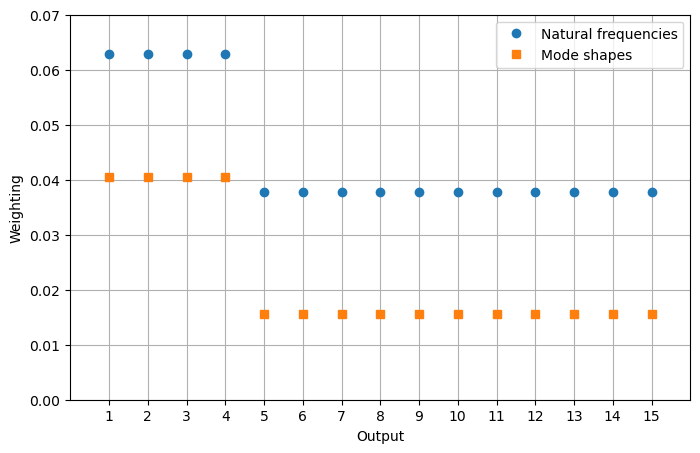

In [5]:
outputs = int(len(info_files[-1]['W']) / 2)
x_list = np.arange(1, outputs+1)

weighting = np.diag(np.around(info_files[-1]['W'], 5))

plt.figure(figsize=(8, 5))
plt.plot(x_list, weighting[:outputs], 'o', label="Natural frequencies")
plt.plot(x_list, weighting[outputs:], 's', label="Mode shapes")
plt.legend()
plt.xticks(x_list)
plt.xlabel("Output")
plt.ylabel("Weighting")
plt.ylim(0,0.07)
plt.xlim(0, 16)
plt.grid()
# plt.savefig("weighting.svg")
plt.show()

In [6]:
J_index = []

for i, analysis in enumerate(analyses):
    J_index.append(np.argmin(info_files[i]['J_star_list']))

J_index

[15, 15, 15, 14, 15, 14, 14]

In [7]:
mac_change = np.zeros(len(J_index))
mmi_change = np.zeros(len(J_index))
freq_error = np.zeros(len(J_index))
objective_function_change = np.zeros(len(J_index))



for analysis, iteration in enumerate(J_index):

    MAC_initial = info_files[analysis]['MAC_initial']
    MAC_updated = info_files[analysis]['MAC_updated']['MAC_updated' + str(iteration)]

    MMI_initial = info_files[analysis]['MMI_initial']
    MMI_updated = info_files[analysis]['MMI_updated']['MMI_updated' + str(iteration)]

    ind_list_initial = []
    ind_list_updated = []
    naming_rows_initial = []
    naming_rows_updated = []

    for i in range(len(MAC_initial[1])):
        ind = np.argsort(MMI_initial[:,i])[::-1]
        ind_list_initial.append(ind[0])
        naming_rows_initial.append(ind[0] + 1)

    MAC_initial_sorted = MAC_initial[ind_list_initial,:]
    MAC_initial_sorted_diag = np.diag(MAC_initial_sorted)

    for i in range(len(MAC_updated[1])):
        ind = np.argsort(MMI_updated[:,i])[::-1]
        ind_list_updated.append(ind[0])
        naming_rows_updated.append(ind[0] + 1)

    MAC_updated_sorted = MAC_updated[ind_list_updated,:]
    MAC_updated_sorted_diag = np.diag(MAC_updated_sorted)

    MAC_change = MAC_updated_sorted_diag - MAC_initial_sorted_diag

    ind_list_initial = []
    ind_list_updated = []
    naming_rows_initial = []
    naming_rows_updated = []

    for i in range(len(MMI_initial[1])):
        ind = np.argsort(MMI_initial[:,i])[::-1]
        ind_list_initial.append(ind[0])
        naming_rows_initial.append(ind[0] + 1)

    MMI_initial_sorted = MMI_initial[ind_list_initial,:]
    MMI_initial_sorted_diag = np.diag(MMI_initial_sorted)

    for i in range(len(MMI_updated[1])):
        ind = np.argsort(MMI_updated[:,i])[::-1]
        ind_list_updated.append(ind[0])
        naming_rows_updated.append(ind[0] + 1)

    MMI_updated_sorted = MMI_updated[ind_list_updated,:]
    MMI_updated_sorted_diag = np.diag(MMI_updated_sorted)

    MMI_change = MMI_updated_sorted_diag - MMI_initial_sorted_diag

    measured_fn = info_files[analysis]['lamda_m'][0:len(MAC_change)]
    mode_array = np.array([int(i+1) for i in range(0, len(measured_fn))])

    initial_fn = info_files[analysis]['lamda'][0, 0:len(MAC_change)]
    initial_error = np.abs(measured_fn - initial_fn) / measured_fn * 100

    updated_fn = info_files[analysis]['lamda'][int(iteration), 0:len(MAC_change)]
    updated_error = np.abs(measured_fn - updated_fn) / measured_fn * 100


    column_names = ["Mode", "Measured f_n", "Initial f_n", "Error [%]", "Updated f_n", "Error [%]", 
                    "Initial MAC", "Updated MAC", "Change", "Initial MMI", "Updated MMI", "Change"]

    columns = np.array([mode_array, np.round(measured_fn, 4), np.round(initial_fn, 4), np.round(initial_error, 2),
                        np.round(updated_fn, 4), np.round(updated_error, 2), np.round(MAC_initial_sorted_diag, 4), 
                        np.round(MAC_updated_sorted_diag, 4), np.round(MAC_change, 4),
                        np.round(MMI_initial_sorted_diag, 4), np.round(MMI_updated_sorted_diag, 4), np.round(MMI_change, 4)])

    mac_table = pd.DataFrame(columns.T, columns=column_names)
    mac_table[["Mode"]] = mac_table[["Mode"]].astype(int)

    j_star_0 = info_files[analysis]['J_star_list'][0]
    j_star = info_files[analysis]['J_star_list'][iteration]
    j_star_change = (j_star - j_star_0) / np.abs(j_star_0) * 100

    mac_change[analysis] = np.sum(MAC_change)
    mmi_change[analysis] = np.sum(MMI_change)
    freq_error[analysis] = np.mean(updated_error)
    objective_function_change[analysis] = j_star_change


    print(f"Analysis: {analyses[analysis]} after iteration {iteration}")
    display(mac_table)
    print(mac_table.to_latex(index=False, float_format="%.3f"))
    print(f"Sum of MAC change = {round(np.sum(MAC_change), 3)}")
    print(f"Sum of MMI change = {round(np.sum(MMI_change), 3)}")
    print(f"Mean updated frequency error = {round(np.mean(updated_error), 2)} %")
    print(f"Change in objective function = {round(j_star_change, 2)} %")
    print("\n")

Analysis: 2.00 after iteration 15


Mode  Measured f_n  Initial f_n  Error [%]  Updated f_n  Error [%]  \
0      1        0.2999       0.2853       4.87       0.2634      12.18   
1      2        0.3839       0.3965       3.27       0.3568       7.07   
2      3        0.6197       0.7004      13.03       0.6257       0.97   
3      4        0.8202       0.9371      14.25       0.8411       2.54   
4      5        1.0875       1.3722      26.18       1.0660       1.98   
5      6        1.2205       1.2991       6.44       1.1315       7.29   
6      7        1.3607       1.6837      23.74       1.4687       7.93   
7      8        1.6172       1.8918      16.98       1.7230       6.54   
8      9        2.1106       2.2030       4.38       2.0722       1.82   
9     10        1.0000       0.8987      10.13       0.9007       9.93   
10    11        1.0000       0.9659       3.41       0.9694       3.06   
11    12        1.0000       0.9278       7.22       0.9372       6.28   
12    13        1.0000       0.7741      22.59       0.8662      13.38   
13    14        1.0000       0.7427      25.73       0.6576      34.24   
14    15        1.0000       0.6751      32.49       0.6893      31.07   

    Initial MAC  Updated MAC  Change  Initial MMI  Updated MMI  Change  
0        0.8987       0.9007  0.0020       0.4250       0.3895 -0.0355  
1        0.9659       0.9694  0.0036       0.4666       0.4494 -0.0172  
2        0.9278       0.9372  0.0094       0.3988       0.4638  0.0650  
3        0.7741       0.8662  0.0921       0.3158       0.4204  0.1046  
4        0.7427       0.6576 -0.0852       0.2405       0.3189  0.0784  
5        0.6751       0.6893  0.0142       0.3053       0.3082  0.0029  
6        0.8858       0.8380 -0.0478       0.3242       0.3794  0.0551  
7        0.7641       0.8569  0.0928       0.2972       0.3957  0.0986  
8        0.4846       0.5469  0.0623       0.2204       0.2644  0.0440  
9        0.6147       0.6643  0.0495       0.2760       0.2887  0.0127  
10       0.6509       0.4848 -0.1661       0.3220       0.1665 -0.1554  
11       0.8500       0.7884 -0.0615       0.3367       0.3799  0.0432  
12       0.6993       0.6951 -0.0042       0.2050       0.3016  0.0966  
13       0.3969       0.4049  0.0079       0.1769       0.1375 -0.0394  
14       0.6135       0.6120 -0.0015       0.1511       0.2598  0.1088

\begin{tabular}{rrrrrrrrrrrr}
\toprule
Mode & Measured f_n & Initial f_n & Error [%] & Updated f_n & Error [%] & Initial MAC & Updated MAC & Change & Initial MMI & Updated MMI & Change \\
\midrule
1 & 0.300 & 0.285 & 4.870 & 0.263 & 12.180 & 0.899 & 0.901 & 0.002 & 0.425 & 0.390 & -0.035 \\
2 & 0.384 & 0.397 & 3.270 & 0.357 & 7.070 & 0.966 & 0.969 & 0.004 & 0.467 & 0.449 & -0.017 \\
3 & 0.620 & 0.700 & 13.030 & 0.626 & 0.970 & 0.928 & 0.937 & 0.009 & 0.399 & 0.464 & 0.065 \\
4 & 0.820 & 0.937 & 14.250 & 0.841 & 2.540 & 0.774 & 0.866 & 0.092 & 0.316 & 0.420 & 0.105 \\
5 & 1.087 & 1.372 & 26.180 & 1.066 & 1.980 & 0.743 & 0.658 & -0.085 & 0.240 & 0.319 & 0.078 \\
6 & 1.220 & 1.299 & 6.440 & 1.131 & 7.290 & 0.675 & 0.689 & 0.014 & 0.305 & 0.308 & 0.003 \\
7 & 1.361 & 1.684 & 23.740 & 1.469 & 7.930 & 0.886 & 0.838 & -0.048 & 0.324 & 0.379 & 0.055 \\
8 & 1.617 & 1.892 & 16.980 & 1.723 & 6.540 & 0.764 & 0.857 & 0.093 & 0.297 & 0.396 & 0.099 \\
9 & 2.111 & 2.203 & 4.380 & 2.072 & 1.820 & 0.485

Mode  Measured f_n  Initial f_n  Error [%]  Updated f_n  Error [%]  \
0      1        0.2999       0.2853       4.87       0.2640      11.96   
1      2        0.3839       0.3965       3.27       0.3577       6.82   
2      3        0.6197       0.7004      13.03       0.6273       1.23   
3      4        0.8202       0.9371      14.25       0.8431       2.79   
4      5        1.0875       1.3722      26.18       1.0661       1.98   
5      6        1.2205       1.2991       6.44       1.1340       7.09   
6      7        1.3607       1.6837      23.74       1.4723       8.20   
7      8        1.6172       1.8918      16.98       1.7258       6.71   
8      9        2.1106       2.2030       4.38       2.0756       1.66   
9     10        2.4478       2.6015       6.28       2.2403       8.48   
10    11        1.0000       0.8987      10.13       0.9007       9.93   
11    12        1.0000       0.9659       3.41       0.9694       3.06   
12    13        1.0000       0.9278       7.22       0.9371       6.29   
13    14        1.0000       0.7741      22.59       0.8656      13.44   
14    15        1.0000       0.7427      25.73       0.6488      35.12   

    Initial MAC  Updated MAC  Change  Initial MMI  Updated MMI  Change  
0        0.8987       0.9007  0.0020       0.4250       0.3905 -0.0345  
1        0.9659       0.9694  0.0036       0.4666       0.4506 -0.0159  
2        0.9278       0.9371  0.0093       0.3988       0.4624  0.0637  
3        0.7741       0.8656  0.0915       0.3158       0.4189  0.1030  
4        0.7427       0.6488 -0.0939       0.2405       0.3145  0.0740  
5        0.6751       0.6896  0.0144       0.3053       0.3093  0.0040  
6        0.8858       0.8390 -0.0469       0.3242       0.3785  0.0543  
7        0.7641       0.8590  0.0950       0.2972       0.3960  0.0988  
8        0.4846       0.5499  0.0654       0.2204       0.2667  0.0463  
9        0.6147       0.6646  0.0498       0.2760       0.2899  0.0139  
10       0.6509       0.4866 -0.1643       0.3220       0.1684 -0.1535  
11       0.8500       0.7900 -0.0599       0.3367       0.3798  0.0431  
12       0.6993       0.7126  0.0133       0.2050       0.3102  0.1052  
13       0.3969       0.4051  0.0082       0.1769       0.1387 -0.0382  
14       0.6135       0.6097 -0.0038       0.1511       0.2575  0.1064

\begin{tabular}{rrrrrrrrrrrr}
\toprule
Mode & Measured f_n & Initial f_n & Error [%] & Updated f_n & Error [%] & Initial MAC & Updated MAC & Change & Initial MMI & Updated MMI & Change \\
\midrule
1 & 0.300 & 0.285 & 4.870 & 0.264 & 11.960 & 0.899 & 0.901 & 0.002 & 0.425 & 0.391 & -0.035 \\
2 & 0.384 & 0.397 & 3.270 & 0.358 & 6.820 & 0.966 & 0.969 & 0.004 & 0.467 & 0.451 & -0.016 \\
3 & 0.620 & 0.700 & 13.030 & 0.627 & 1.230 & 0.928 & 0.937 & 0.009 & 0.399 & 0.462 & 0.064 \\
4 & 0.820 & 0.937 & 14.250 & 0.843 & 2.790 & 0.774 & 0.866 & 0.091 & 0.316 & 0.419 & 0.103 \\
5 & 1.087 & 1.372 & 26.180 & 1.066 & 1.980 & 0.743 & 0.649 & -0.094 & 0.240 & 0.315 & 0.074 \\
6 & 1.220 & 1.299 & 6.440 & 1.134 & 7.090 & 0.675 & 0.690 & 0.014 & 0.305 & 0.309 & 0.004 \\
7 & 1.361 & 1.684 & 23.740 & 1.472 & 8.200 & 0.886 & 0.839 & -0.047 & 0.324 & 0.379 & 0.054 \\
8 & 1.617 & 1.892 & 16.980 & 1.726 & 6.710 & 0.764 & 0.859 & 0.095 & 0.297 & 0.396 & 0.099 \\
9 & 2.111 & 2.203 & 4.380 & 2.076 & 1.660 & 0.485

Mode  Measured f_n  Initial f_n  Error [%]  Updated f_n  Error [%]  \
0      1        0.2999       0.2853       4.87       0.2697      10.07   
1      2        0.3839       0.3965       3.27       0.3561       7.25   
2      3        0.6197       0.7004      13.03       0.6368       2.75   
3      4        0.8202       0.9371      14.25       0.8719       6.30   
4      5        1.0875       1.3722      26.18       1.2820      17.88   
5      6        1.2205       1.2991       6.44       1.2314       0.89   
6      7        1.3607       1.6837      23.74       1.5688      15.30   
7      8        1.6172       1.8918      16.98       1.8567      14.81   
8      9        2.1106       2.2030       4.38       2.0952       0.73   
9     10        2.4478       2.6015       6.28       2.4602       0.51   
10    11        2.7453       2.7645       0.70       2.6102       4.92   
11    12        1.0000       0.8987      10.13       0.8957      10.43   
12    13        1.0000       0.9659       3.41       0.9647       3.53   
13    14        1.0000       0.9278       7.22       0.9334       6.66   
14    15        1.0000       0.7741      22.59       0.8248      17.52   

    Initial MAC  Updated MAC  Change  Initial MMI  Updated MMI  Change  
0        0.8987       0.8957 -0.0030       0.4250       0.3975 -0.0275  
1        0.9659       0.9647 -0.0012       0.4666       0.4461 -0.0205  
2        0.9278       0.9334  0.0055       0.3988       0.4529  0.0542  
3        0.7741       0.8248  0.0507       0.3158       0.3809  0.0651  
4        0.7427       0.7536  0.0109       0.2405       0.2874  0.0469  
5        0.6751       0.6764  0.0012       0.3053       0.3337  0.0284  
6        0.8858       0.8485 -0.0373       0.3242       0.3478  0.0236  
7        0.7641       0.8859  0.1218       0.2972       0.3689  0.0717  
8        0.4846       0.5520  0.0674       0.2204       0.2723  0.0520  
9        0.6147       0.6551  0.0403       0.2760       0.3250  0.0490  
10       0.6509       0.6661  0.0152       0.3220       0.3084 -0.0135  
11       0.8500       0.8776  0.0277       0.3367       0.3793  0.0426  
12       0.6993       0.6860 -0.0133       0.2050       0.2314  0.0265  
13       0.3969       0.3935 -0.0034       0.1769       0.1878  0.0109  
14       0.6135       0.6159  0.0024       0.1511       0.1785  0.0275

\begin{tabular}{rrrrrrrrrrrr}
\toprule
Mode & Measured f_n & Initial f_n & Error [%] & Updated f_n & Error [%] & Initial MAC & Updated MAC & Change & Initial MMI & Updated MMI & Change \\
\midrule
1 & 0.300 & 0.285 & 4.870 & 0.270 & 10.070 & 0.899 & 0.896 & -0.003 & 0.425 & 0.398 & -0.028 \\
2 & 0.384 & 0.397 & 3.270 & 0.356 & 7.250 & 0.966 & 0.965 & -0.001 & 0.467 & 0.446 & -0.021 \\
3 & 0.620 & 0.700 & 13.030 & 0.637 & 2.750 & 0.928 & 0.933 & 0.005 & 0.399 & 0.453 & 0.054 \\
4 & 0.820 & 0.937 & 14.250 & 0.872 & 6.300 & 0.774 & 0.825 & 0.051 & 0.316 & 0.381 & 0.065 \\
5 & 1.087 & 1.372 & 26.180 & 1.282 & 17.880 & 0.743 & 0.754 & 0.011 & 0.240 & 0.287 & 0.047 \\
6 & 1.220 & 1.299 & 6.440 & 1.231 & 0.890 & 0.675 & 0.676 & 0.001 & 0.305 & 0.334 & 0.028 \\
7 & 1.361 & 1.684 & 23.740 & 1.569 & 15.300 & 0.886 & 0.849 & -0.037 & 0.324 & 0.348 & 0.024 \\
8 & 1.617 & 1.892 & 16.980 & 1.857 & 14.810 & 0.764 & 0.886 & 0.122 & 0.297 & 0.369 & 0.072 \\
9 & 2.111 & 2.203 & 4.380 & 2.095 & 0.730 & 0

Mode  Measured f_n  Initial f_n  Error [%]  Updated f_n  Error [%]  \
0      1        0.2999       0.2853       4.87       0.2736       8.75   
1      2        0.3839       0.3965       3.27       0.3725       2.99   
2      3        0.6197       0.7004      13.03       0.6527       5.32   
3      4        0.8202       0.9371      14.25       0.8740       6.56   
4      5        1.0875       1.3722      26.18       1.0765       1.01   
5      6        1.2205       1.2991       6.44       1.1708       4.07   
6      7        1.3607       1.6837      23.74       1.5310      12.51   
7      8        1.6172       1.8918      16.98       1.7676       9.30   
8      9        2.1106       2.2030       4.38       2.1294       0.89   
9     10        2.4478       2.6015       6.28       2.3210       5.18   
10    11        2.7453       2.7645       0.70       2.4381      11.19   
11    12        2.9919       3.5202      17.66       3.1729       6.05   
12    13        1.0000       0.8987      10.13       0.9003       9.97   
13    14        1.0000       0.9659       3.41       0.9690       3.10   
14    15        1.0000       0.9278       7.22       0.9358       6.42   

    Initial MAC  Updated MAC  Change  Initial MMI  Updated MMI  Change  
0        0.8987       0.9003  0.0016       0.4250       0.4064 -0.0186  
1        0.9659       0.9690  0.0032       0.4666       0.4696  0.0030  
2        0.9278       0.9358  0.0079       0.3988       0.4413  0.0425  
3        0.7741       0.8528  0.0787       0.3158       0.3936  0.0778  
4        0.7427       0.5412 -0.2016       0.2405       0.2655  0.0250  
5        0.6751       0.6927  0.0176       0.3053       0.3260  0.0207  
6        0.8858       0.8561 -0.0297       0.3242       0.3655  0.0413  
7        0.7641       0.8726  0.1085       0.2972       0.3898  0.0927  
8        0.4846       0.5740  0.0894       0.2204       0.2826  0.0622  
9        0.6147       0.6686  0.0538       0.2760       0.3084  0.0324  
10       0.6509       0.5294 -0.1215       0.3220       0.2087 -0.1132  
11       0.8500       0.8216 -0.0284       0.3367       0.3805  0.0439  
12       0.6993       0.6927 -0.0067       0.2050       0.2856  0.0806  
13       0.3969       0.4091  0.0121       0.1769       0.1579 -0.0190  
14       0.6135       0.6082 -0.0053       0.1511       0.2180  0.0669

\begin{tabular}{rrrrrrrrrrrr}
\toprule
Mode & Measured f_n & Initial f_n & Error [%] & Updated f_n & Error [%] & Initial MAC & Updated MAC & Change & Initial MMI & Updated MMI & Change \\
\midrule
1 & 0.300 & 0.285 & 4.870 & 0.274 & 8.750 & 0.899 & 0.900 & 0.002 & 0.425 & 0.406 & -0.019 \\
2 & 0.384 & 0.397 & 3.270 & 0.372 & 2.990 & 0.966 & 0.969 & 0.003 & 0.467 & 0.470 & 0.003 \\
3 & 0.620 & 0.700 & 13.030 & 0.653 & 5.320 & 0.928 & 0.936 & 0.008 & 0.399 & 0.441 & 0.043 \\
4 & 0.820 & 0.937 & 14.250 & 0.874 & 6.560 & 0.774 & 0.853 & 0.079 & 0.316 & 0.394 & 0.078 \\
5 & 1.087 & 1.372 & 26.180 & 1.077 & 1.010 & 0.743 & 0.541 & -0.202 & 0.240 & 0.266 & 0.025 \\
6 & 1.220 & 1.299 & 6.440 & 1.171 & 4.070 & 0.675 & 0.693 & 0.018 & 0.305 & 0.326 & 0.021 \\
7 & 1.361 & 1.684 & 23.740 & 1.531 & 12.510 & 0.886 & 0.856 & -0.030 & 0.324 & 0.365 & 0.041 \\
8 & 1.617 & 1.892 & 16.980 & 1.768 & 9.300 & 0.764 & 0.873 & 0.108 & 0.297 & 0.390 & 0.093 \\
9 & 2.111 & 2.203 & 4.380 & 2.129 & 0.890 & 0.485 

Mode  Measured f_n  Initial f_n  Error [%]  Updated f_n  Error [%]  \
0      1        0.2999       0.2853       4.87       0.2735       8.78   
1      2        0.3839       0.3965       3.27       0.3725       2.98   
2      3        0.6197       0.7004      13.03       0.6524       5.28   
3      4        0.8202       0.9371      14.25       0.8734       6.48   
4      5        1.0875       1.3722      26.18       1.0758       1.08   
5      6        1.2205       1.2991       6.44       1.1690       4.22   
6      7        1.3607       1.6837      23.74       1.5294      12.40   
7      8        1.6172       1.8918      16.98       1.7659       9.20   
8      9        2.1106       2.2030       4.38       2.1265       0.75   
9     10        2.4478       2.6015       6.28       2.3171       5.34   
10    11        2.7453       2.7645       0.70       2.4332      11.37   
11    12        2.9919       3.5202      17.66       3.1684       5.90   
12    13        3.3295       4.2930      28.94       3.7254      11.89   
13    14        1.0000       0.8987      10.13       0.9003       9.97   
14    15        1.0000       0.9659       3.41       0.9690       3.10   

    Initial MAC  Updated MAC  Change  Initial MMI  Updated MMI  Change  
0        0.8987       0.9003  0.0016       0.4250       0.4062 -0.0187  
1        0.9659       0.9690  0.0032       0.4666       0.4696  0.0031  
2        0.9278       0.9356  0.0078       0.3988       0.4414  0.0426  
3        0.7741       0.8533  0.0792       0.3158       0.3942  0.0784  
4        0.7427       0.5430 -0.1997       0.2405       0.2661  0.0256  
5        0.6751       0.6930  0.0179       0.3053       0.3254  0.0201  
6        0.8858       0.8548 -0.0310       0.3242       0.3654  0.0412  
7        0.7641       0.8725  0.1084       0.2972       0.3902  0.0931  
8        0.4846       0.5760  0.0915       0.2204       0.2843  0.0639  
9        0.6147       0.6687  0.0540       0.2760       0.3076  0.0317  
10       0.6509       0.5259 -0.1250       0.3220       0.2061 -0.1158  
11       0.8500       0.8194 -0.0305       0.3367       0.3802  0.0435  
12       0.6993       0.6939 -0.0054       0.2050       0.2875  0.0825  
13       0.3969       0.4098  0.0128       0.1769       0.1573 -0.0196  
14       0.6135       0.6005 -0.0130       0.1511       0.2148  0.0637

\begin{tabular}{rrrrrrrrrrrr}
\toprule
Mode & Measured f_n & Initial f_n & Error [%] & Updated f_n & Error [%] & Initial MAC & Updated MAC & Change & Initial MMI & Updated MMI & Change \\
\midrule
1 & 0.300 & 0.285 & 4.870 & 0.274 & 8.780 & 0.899 & 0.900 & 0.002 & 0.425 & 0.406 & -0.019 \\
2 & 0.384 & 0.397 & 3.270 & 0.372 & 2.980 & 0.966 & 0.969 & 0.003 & 0.467 & 0.470 & 0.003 \\
3 & 0.620 & 0.700 & 13.030 & 0.652 & 5.280 & 0.928 & 0.936 & 0.008 & 0.399 & 0.441 & 0.043 \\
4 & 0.820 & 0.937 & 14.250 & 0.873 & 6.480 & 0.774 & 0.853 & 0.079 & 0.316 & 0.394 & 0.078 \\
5 & 1.087 & 1.372 & 26.180 & 1.076 & 1.080 & 0.743 & 0.543 & -0.200 & 0.240 & 0.266 & 0.026 \\
6 & 1.220 & 1.299 & 6.440 & 1.169 & 4.220 & 0.675 & 0.693 & 0.018 & 0.305 & 0.325 & 0.020 \\
7 & 1.361 & 1.684 & 23.740 & 1.529 & 12.400 & 0.886 & 0.855 & -0.031 & 0.324 & 0.365 & 0.041 \\
8 & 1.617 & 1.892 & 16.980 & 1.766 & 9.200 & 0.764 & 0.873 & 0.108 & 0.297 & 0.390 & 0.093 \\
9 & 2.111 & 2.203 & 4.380 & 2.127 & 0.750 & 0.485 

Mode  Measured f_n  Initial f_n  Error [%]  Updated f_n  Error [%]  \
0      1        0.2999       0.2853       4.87       0.2743       8.52   
1      2        0.3839       0.3965       3.27       0.3736       2.70   
2      3        0.6197       0.7004      13.03       0.6544       5.60   
3      4        0.8202       0.9371      14.25       0.8757       6.76   
4      5        1.0875       1.3722      26.18       1.0777       0.91   
5      6        1.2205       1.2991       6.44       1.1719       3.98   
6      7        1.3607       1.6837      23.74       1.5337      12.71   
7      8        1.6172       1.8918      16.98       1.7682       9.34   
8      9        2.1106       2.2030       4.38       2.1302       0.93   
9     10        2.4478       2.6015       6.28       2.3235       5.08   
10    11        2.7453       2.7645       0.70       2.4404      11.11   
11    12        2.9919       3.5202      17.66       3.1752       6.13   
12    13        3.3295       4.2930      28.94       3.7362      12.21   
13    14        3.5573       3.7107       4.31       3.2287       9.24   
14    15        1.0000       0.8987      10.13       0.9003       9.97   

    Initial MAC  Updated MAC  Change  Initial MMI  Updated MMI  Change  
0        0.8987       0.9003  0.0016       0.4250       0.4075 -0.0175  
1        0.9659       0.9690  0.0032       0.4666       0.4710  0.0045  
2        0.9278       0.9354  0.0076       0.3988       0.4397  0.0410  
3        0.7741       0.8521  0.0780       0.3158       0.3922  0.0764  
4        0.7427       0.5402 -0.2026       0.2405       0.2656  0.0251  
5        0.6751       0.6932  0.0181       0.3053       0.3267  0.0214  
6        0.8858       0.8560 -0.0298       0.3242       0.3644  0.0402  
7        0.7641       0.8712  0.1071       0.2972       0.3889  0.0918  
8        0.4846       0.5764  0.0918       0.2204       0.2835  0.0631  
9        0.6147       0.6690  0.0543       0.2760       0.3091  0.0331  
10       0.6509       0.5270 -0.1240       0.3220       0.2079 -0.1140  
11       0.8500       0.8219 -0.0281       0.3367       0.3803  0.0436  
12       0.6993       0.6952 -0.0042       0.2050       0.2865  0.0815  
13       0.3969       0.4101  0.0132       0.1769       0.1589 -0.0180  
14       0.6135       0.6118 -0.0017       0.1511       0.2195  0.0685

\begin{tabular}{rrrrrrrrrrrr}
\toprule
Mode & Measured f_n & Initial f_n & Error [%] & Updated f_n & Error [%] & Initial MAC & Updated MAC & Change & Initial MMI & Updated MMI & Change \\
\midrule
1 & 0.300 & 0.285 & 4.870 & 0.274 & 8.520 & 0.899 & 0.900 & 0.002 & 0.425 & 0.407 & -0.018 \\
2 & 0.384 & 0.397 & 3.270 & 0.374 & 2.700 & 0.966 & 0.969 & 0.003 & 0.467 & 0.471 & 0.004 \\
3 & 0.620 & 0.700 & 13.030 & 0.654 & 5.600 & 0.928 & 0.935 & 0.008 & 0.399 & 0.440 & 0.041 \\
4 & 0.820 & 0.937 & 14.250 & 0.876 & 6.760 & 0.774 & 0.852 & 0.078 & 0.316 & 0.392 & 0.076 \\
5 & 1.087 & 1.372 & 26.180 & 1.078 & 0.910 & 0.743 & 0.540 & -0.203 & 0.240 & 0.266 & 0.025 \\
6 & 1.220 & 1.299 & 6.440 & 1.172 & 3.980 & 0.675 & 0.693 & 0.018 & 0.305 & 0.327 & 0.021 \\
7 & 1.361 & 1.684 & 23.740 & 1.534 & 12.710 & 0.886 & 0.856 & -0.030 & 0.324 & 0.364 & 0.040 \\
8 & 1.617 & 1.892 & 16.980 & 1.768 & 9.340 & 0.764 & 0.871 & 0.107 & 0.297 & 0.389 & 0.092 \\
9 & 2.111 & 2.203 & 4.380 & 2.130 & 0.930 & 0.485 

Mode  Measured f_n  Initial f_n  Error [%]  Updated f_n  Error [%]  \
0      1        0.2999       0.2853       4.87       0.2762       7.91   
1      2        0.3839       0.3965       3.27       0.3741       2.55   
2      3        0.6197       0.7004      13.03       0.6583       6.24   
3      4        0.8202       0.9371      14.25       0.8843       7.81   
4      5        1.0875       1.3722      26.18       1.0881       0.05   
5      6        1.2205       1.2991       6.44       1.1982       1.83   
6      7        1.3607       1.6837      23.74       1.5576      14.47   
7      8        1.6172       1.8918      16.98       1.7960      11.06   
8      9        2.1106       2.2030       4.38       2.0202       4.29   
9     10        2.4478       2.6015       6.28       2.3815       2.71   
10    11        2.7453       2.7645       0.70       2.5064       8.70   
11    12        2.9919       3.5202      17.66       3.2391       8.26   
12    13        3.3295       4.2930      28.94       3.8547      15.77   
13    14        3.5573       3.7107       4.31       3.3273       6.47   
14    15        4.5354       5.9478      31.14       5.4227      19.56   

    Initial MAC  Updated MAC  Change  Initial MMI  Updated MMI  Change  
0        0.8987       0.8993  0.0006       0.4250       0.4101 -0.0149  
1        0.9659       0.9685  0.0026       0.4666       0.4715  0.0049  
2        0.9278       0.9365  0.0086       0.3988       0.4370  0.0383  
3        0.7741       0.8444  0.0703       0.3158       0.3832  0.0674  
4        0.7427       0.5132 -0.2295       0.2405       0.2564  0.0159  
5        0.6751       0.6893  0.0142       0.3053       0.3355  0.0302  
6        0.8858       0.8673 -0.0185       0.3242       0.3613  0.0371  
7        0.7641       0.8742  0.1102       0.2972       0.3818  0.0847  
8        0.4846       0.5598  0.0752       0.2204       0.2585  0.0381  
9        0.6147       0.6665  0.0518       0.2760       0.3197  0.0437  
10       0.6509       0.5669 -0.0840       0.3220       0.2399 -0.0820  
11       0.8500       0.8487 -0.0013       0.3367       0.3830  0.0463  
12       0.6993       0.6959 -0.0034       0.2050       0.2691  0.0641  
13       0.3969       0.4018  0.0049       0.1769       0.1686 -0.0083  
14       0.6135       0.6819  0.0684       0.1511       0.2431  0.0921

\begin{tabular}{rrrrrrrrrrrr}
\toprule
Mode & Measured f_n & Initial f_n & Error [%] & Updated f_n & Error [%] & Initial MAC & Updated MAC & Change & Initial MMI & Updated MMI & Change \\
\midrule
1 & 0.300 & 0.285 & 4.870 & 0.276 & 7.910 & 0.899 & 0.899 & 0.001 & 0.425 & 0.410 & -0.015 \\
2 & 0.384 & 0.397 & 3.270 & 0.374 & 2.550 & 0.966 & 0.969 & 0.003 & 0.467 & 0.471 & 0.005 \\
3 & 0.620 & 0.700 & 13.030 & 0.658 & 6.240 & 0.928 & 0.936 & 0.009 & 0.399 & 0.437 & 0.038 \\
4 & 0.820 & 0.937 & 14.250 & 0.884 & 7.810 & 0.774 & 0.844 & 0.070 & 0.316 & 0.383 & 0.067 \\
5 & 1.087 & 1.372 & 26.180 & 1.088 & 0.050 & 0.743 & 0.513 & -0.230 & 0.240 & 0.256 & 0.016 \\
6 & 1.220 & 1.299 & 6.440 & 1.198 & 1.830 & 0.675 & 0.689 & 0.014 & 0.305 & 0.336 & 0.030 \\
7 & 1.361 & 1.684 & 23.740 & 1.558 & 14.470 & 0.886 & 0.867 & -0.018 & 0.324 & 0.361 & 0.037 \\
8 & 1.617 & 1.892 & 16.980 & 1.796 & 11.060 & 0.764 & 0.874 & 0.110 & 0.297 & 0.382 & 0.085 \\
9 & 2.111 & 2.203 & 4.380 & 2.020 & 4.290 & 0.485

In [8]:
analyses_float = [2.00, 2.22, 2.44, 2.67, 2.89, 3.11, 3.33]

columns = np.array([analyses_float, mac_change, mmi_change, freq_error, objective_function_change, J_index])
column_names = np.array(["Sytem ratio ($r_{os}$)", "MAC change", "MMI change", "Mean frequency error", "J* change", "No. iterations"])

analysis_table = pd.DataFrame(columns.T, columns=column_names)
analysis_table["No. iterations"] = analysis_table["No. iterations"].astype(int)

analysis_table

print(analysis_table.to_latex(index=False, float_format="%.4f"))

\begin{tabular}{rrrrrr}
\toprule
Sytem ratio ($r_{os}$) & MAC change & MMI change & Mean frequency error & J* change & No. iterations \\
\midrule
2.0000 & -0.0323 & 0.4623 & 9.7509 & -37.1062 & 15 \\
2.2200 & -0.0165 & 0.4706 & 8.3169 & -34.6580 & 15 \\
2.4400 & 0.2849 & 0.4367 & 7.9711 & -28.2840 & 15 \\
2.6700 & -0.0202 & 0.4381 & 6.2210 & -20.3541 & 14 \\
2.8900 & -0.0284 & 0.4352 & 6.5825 & -23.8949 & 15 \\
3.1100 & -0.0156 & 0.4406 & 7.0121 & -19.6242 & 14 \\
3.3300 & 0.0701 & 0.4575 & 7.8454 & -22.0349 & 14 \\
\bottomrule
\end{tabular}



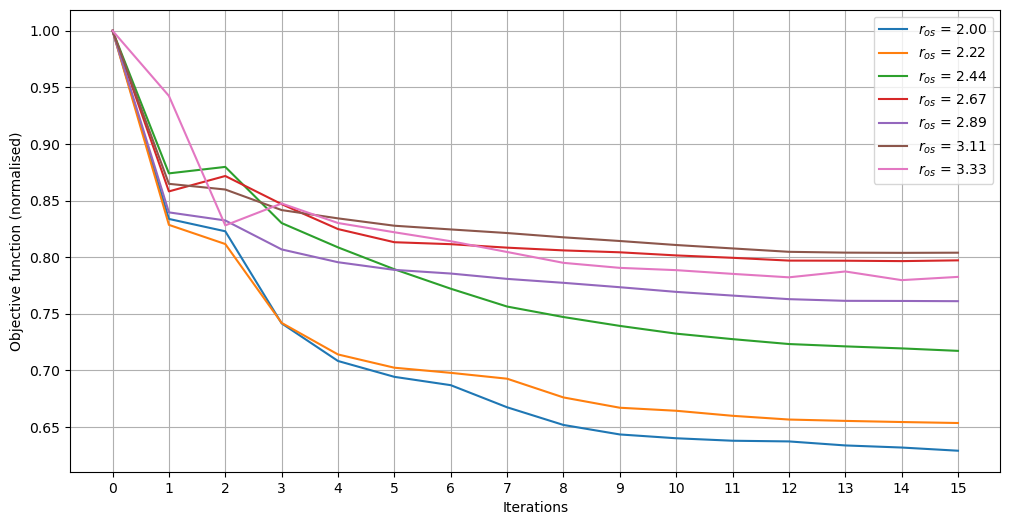

In [9]:


plt.figure(figsize=(12,6))
for i in range(len(J_index)):
    plt.plot(np.arange(0,16), info_files[i]['J_star_list'] / np.max(info_files[i]['J_star_list'][0]), label="$r_{os}$ = " + analyses[i])
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Objective function (normalised)")
plt.xticks(np.arange(0,16))
plt.legend()
# plt.savefig("./pictures/objective_function_graph_set_2.svg")

plt.show()

In [10]:
for analysis, iteration in enumerate(J_index):
    parameter = [r'$E_{s,b}$', r'$\rho_s$', r'$E_{c,t}$', r'$E_{s,c}$', r'$k_y$', r'$k_z$', 
                r'$k_{\phi_x}$', r'$k_{\phi_y}$', r'$k_{\phi_z}$']

    parameter_ref_value = info_files[analysis]["theta"][0]
    parameter_upd_value = info_files[analysis]["theta"][int(iteration)]
    parameter_change = (parameter_upd_value - parameter_ref_value) / parameter_ref_value * 100

    parameter_ref_value_scientific = ["{:.3e}".format(i) for i in parameter_ref_value]
    parameter_upd_value_scientific = ["{:.3e}".format(i) for i in parameter_upd_value]

    parameter_column = ["Parameter", "Referance value", "Updated value", "Change [%]"]
    parameter_columns = np.array([parameter, parameter_ref_value_scientific, parameter_upd_value_scientific, np.around(parameter_change, 2)])

    pd.reset_option('display.float_format')
    parameter_table = pd.DataFrame(parameter_columns.T, columns=parameter_column)
    print(pd.DataFrame.to_latex(parameter_table))

    print(f"Analysis: {analyses[analysis]}")
    display(parameter_table)

\begin{tabular}{lllll}
\toprule
 & Parameter & Referance value & Updated value & Change [%] \\
\midrule
0 & $E_{s,b}$ & 2.100e+11 & 1.500e+11 & -28.57 \\
1 & $\rho_s$ & 7.850e+03 & 1.000e+04 & 27.39 \\
2 & $E_{c,t}$ & 2.700e+10 & 3.500e+10 & 29.63 \\
3 & $E_{s,c}$ & 2.500e+03 & 2.900e+03 & 16.0 \\
4 & $k_y$ & 1.000e+10 & 2.488e+10 & 148.83 \\
5 & $k_z$ & 1.000e+10 & 3.518e+08 & -96.48 \\
6 & $k_{\phi_x}$ & 1.000e+12 & 3.440e+12 & 243.99 \\
7 & $k_{\phi_y}$ & 1.000e+12 & 5.278e+10 & -94.72 \\
8 & $k_{\phi_z}$ & 1.000e+12 & 2.488e+12 & 148.83 \\
\bottomrule
\end{tabular}

Analysis: 2.00


Parameter Referance value Updated value Change [%]
0     $E_{s,b}$       2.100e+11     1.500e+11     -28.57
1      $\rho_s$       7.850e+03     1.000e+04      27.39
2     $E_{c,t}$       2.700e+10     3.500e+10      29.63
3     $E_{s,c}$       2.500e+03     2.900e+03       16.0
4         $k_y$       1.000e+10     2.488e+10     148.83
5         $k_z$       1.000e+10     3.518e+08     -96.48
6  $k_{\phi_x}$       1.000e+12     3.440e+12     243.99
7  $k_{\phi_y}$       1.000e+12     5.278e+10     -94.72
8  $k_{\phi_z}$       1.000e+12     2.488e+12     148.83

\begin{tabular}{lllll}
\toprule
 & Parameter & Referance value & Updated value & Change [%] \\
\midrule
0 & $E_{s,b}$ & 2.100e+11 & 1.500e+11 & -28.57 \\
1 & $\rho_s$ & 7.850e+03 & 1.000e+04 & 27.39 \\
2 & $E_{c,t}$ & 2.700e+10 & 3.500e+10 & 29.63 \\
3 & $E_{s,c}$ & 2.500e+03 & 2.876e+03 & 15.03 \\
4 & $k_y$ & 1.000e+10 & 2.488e+10 & 148.83 \\
5 & $k_z$ & 1.000e+10 & 3.518e+08 & -96.48 \\
6 & $k_{\phi_x}$ & 1.000e+12 & 4.953e+12 & 395.34 \\
7 & $k_{\phi_y}$ & 1.000e+12 & 5.278e+10 & -94.72 \\
8 & $k_{\phi_z}$ & 1.000e+12 & 2.986e+12 & 198.6 \\
\bottomrule
\end{tabular}

Analysis: 2.22


Parameter Referance value Updated value Change [%]
0     $E_{s,b}$       2.100e+11     1.500e+11     -28.57
1      $\rho_s$       7.850e+03     1.000e+04      27.39
2     $E_{c,t}$       2.700e+10     3.500e+10      29.63
3     $E_{s,c}$       2.500e+03     2.876e+03      15.03
4         $k_y$       1.000e+10     2.488e+10     148.83
5         $k_z$       1.000e+10     3.518e+08     -96.48
6  $k_{\phi_x}$       1.000e+12     4.953e+12     395.34
7  $k_{\phi_y}$       1.000e+12     5.278e+10     -94.72
8  $k_{\phi_z}$       1.000e+12     2.986e+12      198.6

\begin{tabular}{lllll}
\toprule
 & Parameter & Referance value & Updated value & Change [%] \\
\midrule
0 & $E_{s,b}$ & 2.100e+11 & 2.420e+11 & 15.25 \\
1 & $\rho_s$ & 7.850e+03 & 1.000e+04 & 27.39 \\
2 & $E_{c,t}$ & 2.700e+10 & 3.500e+10 & 29.63 \\
3 & $E_{s,c}$ & 2.500e+03 & 3.303e+03 & 32.14 \\
4 & $k_y$ & 1.000e+10 & 2.074e+10 & 107.36 \\
5 & $k_z$ & 1.000e+10 & 4.008e+09 & -59.92 \\
6 & $k_{\phi_x}$ & 1.000e+12 & 3.518e+10 & -96.48 \\
7 & $k_{\phi_y}$ & 1.000e+12 & 3.518e+10 & -96.48 \\
8 & $k_{\phi_z}$ & 1.000e+12 & 2.488e+12 & 148.83 \\
\bottomrule
\end{tabular}

Analysis: 2.44


Parameter Referance value Updated value Change [%]
0     $E_{s,b}$       2.100e+11     2.420e+11      15.25
1      $\rho_s$       7.850e+03     1.000e+04      27.39
2     $E_{c,t}$       2.700e+10     3.500e+10      29.63
3     $E_{s,c}$       2.500e+03     3.303e+03      32.14
4         $k_y$       1.000e+10     2.074e+10     107.36
5         $k_z$       1.000e+10     4.008e+09     -59.92
6  $k_{\phi_x}$       1.000e+12     3.518e+10     -96.48
7  $k_{\phi_y}$       1.000e+12     3.518e+10     -96.48
8  $k_{\phi_z}$       1.000e+12     2.488e+12     148.83

\begin{tabular}{lllll}
\toprule
 & Parameter & Referance value & Updated value & Change [%] \\
\midrule
0 & $E_{s,b}$ & 2.100e+11 & 1.511e+11 & -28.04 \\
1 & $\rho_s$ & 7.850e+03 & 1.000e+04 & 27.39 \\
2 & $E_{c,t}$ & 2.700e+10 & 3.500e+10 & 29.63 \\
3 & $E_{s,c}$ & 2.500e+03 & 2.537e+03 & 1.49 \\
4 & $k_y$ & 1.000e+10 & 2.488e+10 & 148.83 \\
5 & $k_z$ & 1.000e+10 & 7.514e+09 & -24.86 \\
6 & $k_{\phi_x}$ & 1.000e+12 & 3.977e+12 & 297.72 \\
7 & $k_{\phi_y}$ & 1.000e+12 & 1.484e+11 & -85.16 \\
8 & $k_{\phi_z}$ & 1.000e+12 & 2.488e+12 & 148.83 \\
\bottomrule
\end{tabular}

Analysis: 2.67


Parameter Referance value Updated value Change [%]
0     $E_{s,b}$       2.100e+11     1.511e+11     -28.04
1      $\rho_s$       7.850e+03     1.000e+04      27.39
2     $E_{c,t}$       2.700e+10     3.500e+10      29.63
3     $E_{s,c}$       2.500e+03     2.537e+03       1.49
4         $k_y$       1.000e+10     2.488e+10     148.83
5         $k_z$       1.000e+10     7.514e+09     -24.86
6  $k_{\phi_x}$       1.000e+12     3.977e+12     297.72
7  $k_{\phi_y}$       1.000e+12     1.484e+11     -85.16
8  $k_{\phi_z}$       1.000e+12     2.488e+12     148.83

\begin{tabular}{lllll}
\toprule
 & Parameter & Referance value & Updated value & Change [%] \\
\midrule
0 & $E_{s,b}$ & 2.100e+11 & 1.500e+11 & -28.57 \\
1 & $\rho_s$ & 7.850e+03 & 1.000e+04 & 27.39 \\
2 & $E_{c,t}$ & 2.700e+10 & 3.500e+10 & 29.63 \\
3 & $E_{s,c}$ & 2.500e+03 & 2.533e+03 & 1.33 \\
4 & $k_y$ & 1.000e+10 & 3.583e+10 & 258.32 \\
5 & $k_z$ & 1.000e+10 & 4.008e+09 & -59.92 \\
6 & $k_{\phi_x}$ & 1.000e+12 & 3.440e+12 & 243.99 \\
7 & $k_{\phi_y}$ & 1.000e+12 & 2.672e+11 & -73.28 \\
8 & $k_{\phi_z}$ & 1.000e+12 & 3.583e+12 & 258.32 \\
\bottomrule
\end{tabular}

Analysis: 2.89


Parameter Referance value Updated value Change [%]
0     $E_{s,b}$       2.100e+11     1.500e+11     -28.57
1      $\rho_s$       7.850e+03     1.000e+04      27.39
2     $E_{c,t}$       2.700e+10     3.500e+10      29.63
3     $E_{s,c}$       2.500e+03     2.533e+03       1.33
4         $k_y$       1.000e+10     3.583e+10     258.32
5         $k_z$       1.000e+10     4.008e+09     -59.92
6  $k_{\phi_x}$       1.000e+12     3.440e+12     243.99
7  $k_{\phi_y}$       1.000e+12     2.672e+11     -73.28
8  $k_{\phi_z}$       1.000e+12     3.583e+12     258.32

\begin{tabular}{lllll}
\toprule
 & Parameter & Referance value & Updated value & Change [%] \\
\midrule
0 & $E_{s,b}$ & 2.100e+11 & 1.500e+11 & -28.57 \\
1 & $\rho_s$ & 7.850e+03 & 1.000e+04 & 27.39 \\
2 & $E_{c,t}$ & 2.700e+10 & 3.500e+10 & 29.63 \\
3 & $E_{s,c}$ & 2.500e+03 & 2.506e+03 & 0.25 \\
4 & $k_y$ & 1.000e+10 & 2.986e+10 & 198.6 \\
5 & $k_z$ & 1.000e+10 & 3.340e+09 & -66.6 \\
6 & $k_{\phi_x}$ & 1.000e+12 & 4.128e+12 & 312.78 \\
7 & $k_{\phi_y}$ & 1.000e+12 & 1.484e+11 & -85.16 \\
8 & $k_{\phi_z}$ & 1.000e+12 & 2.986e+12 & 198.6 \\
\bottomrule
\end{tabular}

Analysis: 3.11


Parameter Referance value Updated value Change [%]
0     $E_{s,b}$       2.100e+11     1.500e+11     -28.57
1      $\rho_s$       7.850e+03     1.000e+04      27.39
2     $E_{c,t}$       2.700e+10     3.500e+10      29.63
3     $E_{s,c}$       2.500e+03     2.506e+03       0.25
4         $k_y$       1.000e+10     2.986e+10      198.6
5         $k_z$       1.000e+10     3.340e+09      -66.6
6  $k_{\phi_x}$       1.000e+12     4.128e+12     312.78
7  $k_{\phi_y}$       1.000e+12     1.484e+11     -85.16
8  $k_{\phi_z}$       1.000e+12     2.986e+12      198.6

\begin{tabular}{lllll}
\toprule
 & Parameter & Referance value & Updated value & Change [%] \\
\midrule
0 & $E_{s,b}$ & 2.100e+11 & 1.665e+11 & -20.71 \\
1 & $\rho_s$ & 7.850e+03 & 1.000e+04 & 27.39 \\
2 & $E_{c,t}$ & 2.700e+10 & 3.500e+10 & 29.63 \\
3 & $E_{s,c}$ & 2.500e+03 & 2.556e+03 & 2.26 \\
4 & $k_y$ & 1.000e+10 & 2.488e+10 & 148.83 \\
5 & $k_z$ & 1.000e+10 & 3.340e+09 & -66.6 \\
6 & $k_{\phi_x}$ & 1.000e+12 & 3.963e+12 & 296.27 \\
7 & $k_{\phi_y}$ & 1.000e+12 & 4.398e+10 & -95.6 \\
8 & $k_{\phi_z}$ & 1.000e+12 & 2.986e+12 & 198.6 \\
\bottomrule
\end{tabular}

Analysis: 3.33


Parameter Referance value Updated value Change [%]
0     $E_{s,b}$       2.100e+11     1.665e+11     -20.71
1      $\rho_s$       7.850e+03     1.000e+04      27.39
2     $E_{c,t}$       2.700e+10     3.500e+10      29.63
3     $E_{s,c}$       2.500e+03     2.556e+03       2.26
4         $k_y$       1.000e+10     2.488e+10     148.83
5         $k_z$       1.000e+10     3.340e+09      -66.6
6  $k_{\phi_x}$       1.000e+12     3.963e+12     296.27
7  $k_{\phi_y}$       1.000e+12     4.398e+10      -95.6
8  $k_{\phi_z}$       1.000e+12     2.986e+12      198.6

C:\Users\marku\AppData\Local\Temp\ipykernel_24940\439762619.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(analysis * 10 + 3, figsize=(10, 8))


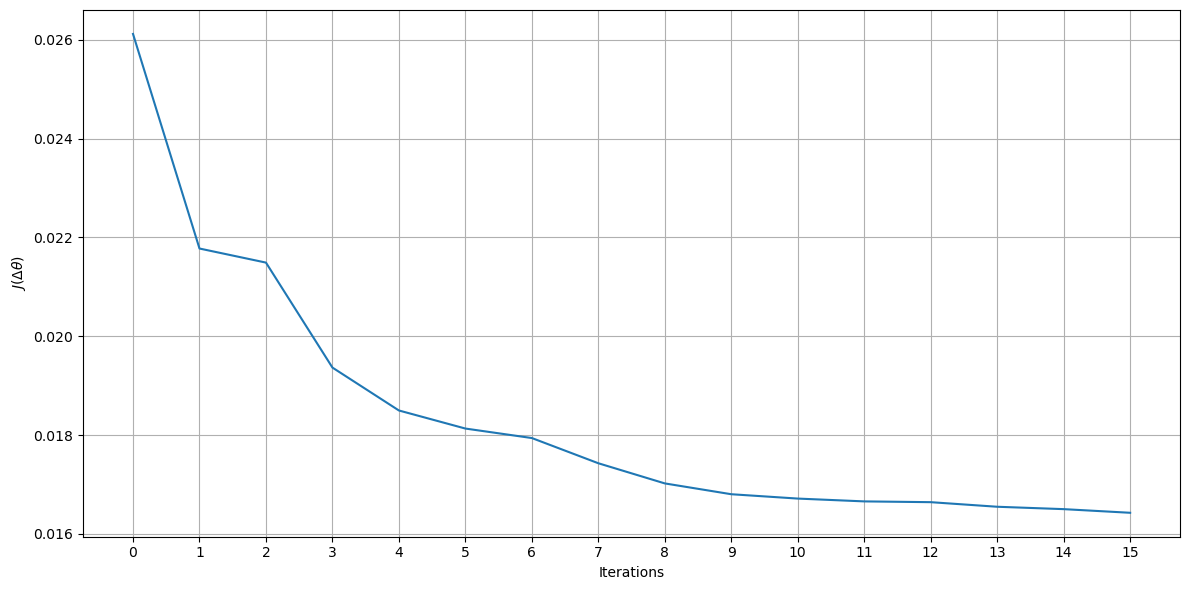

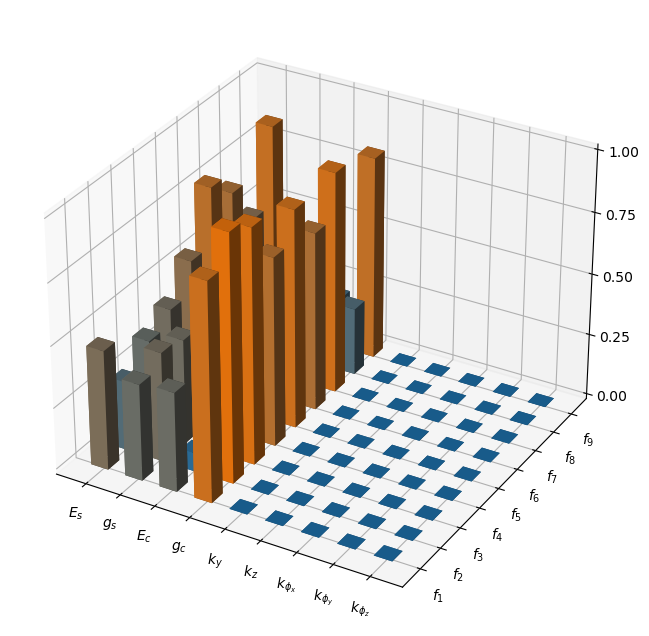

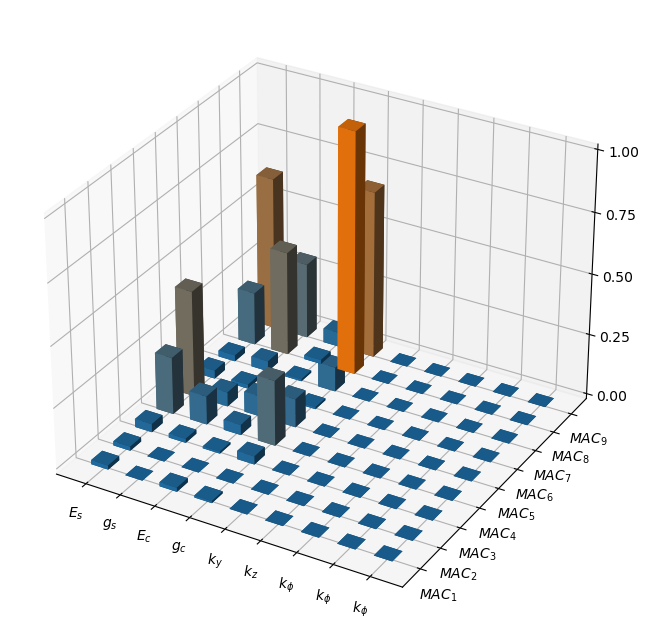

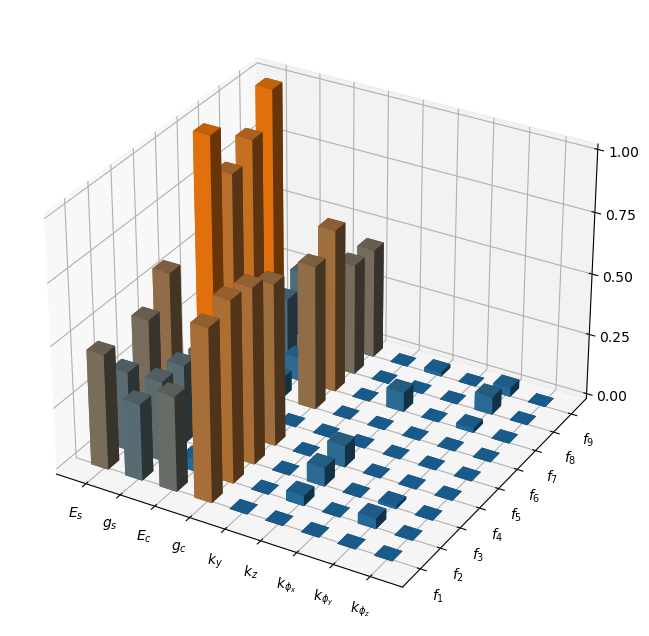

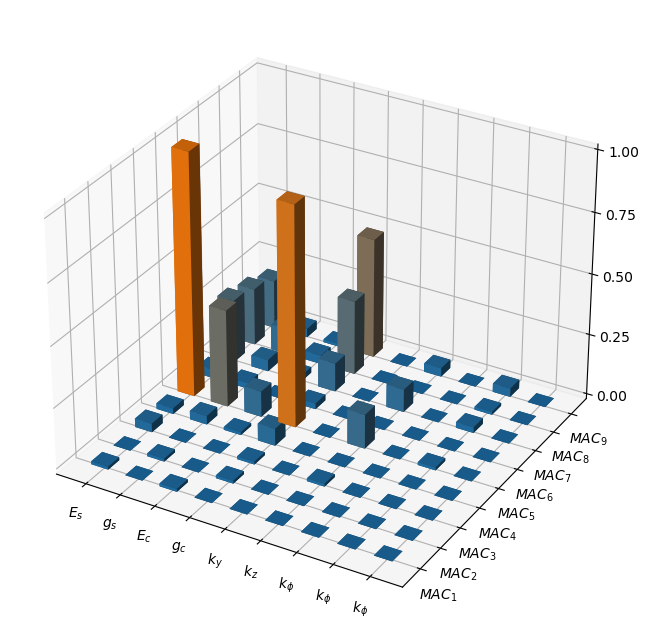

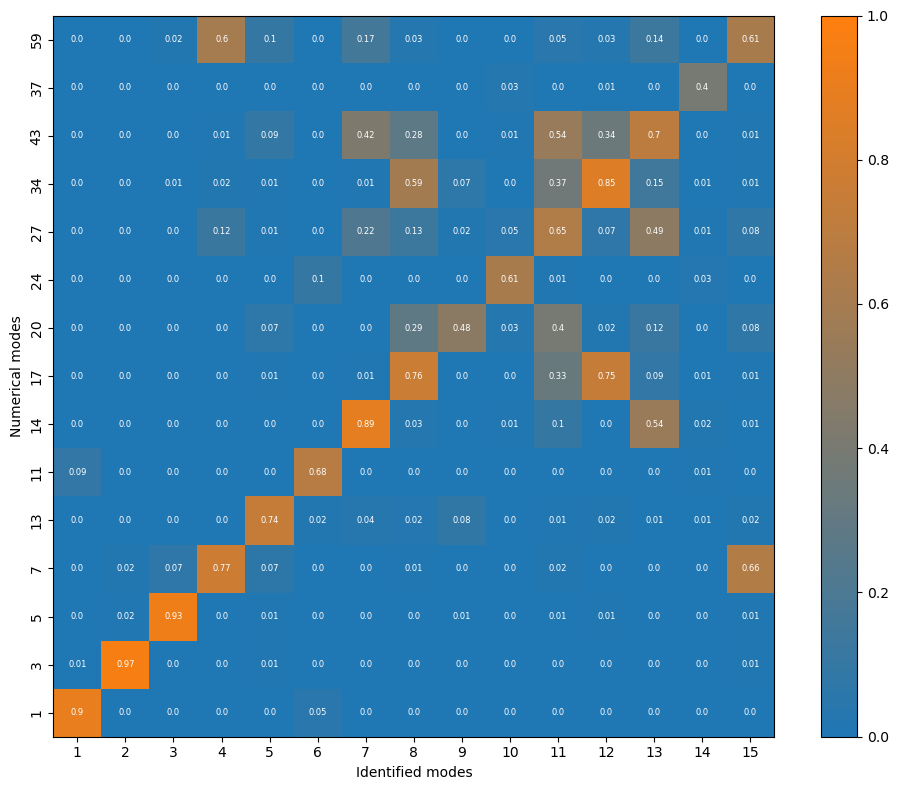

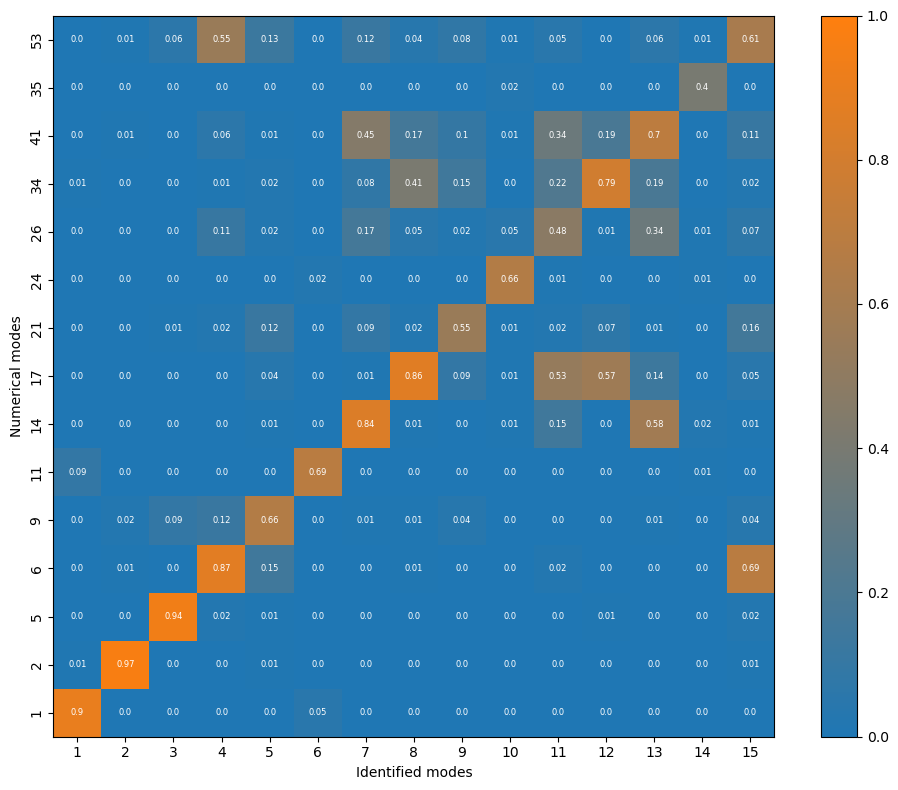

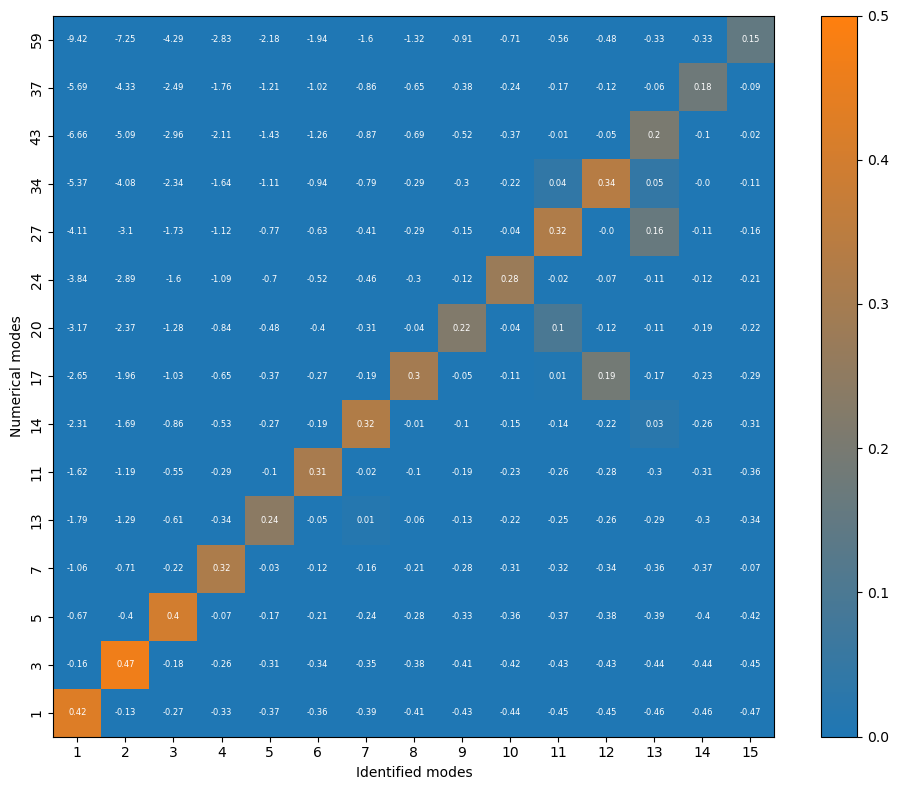

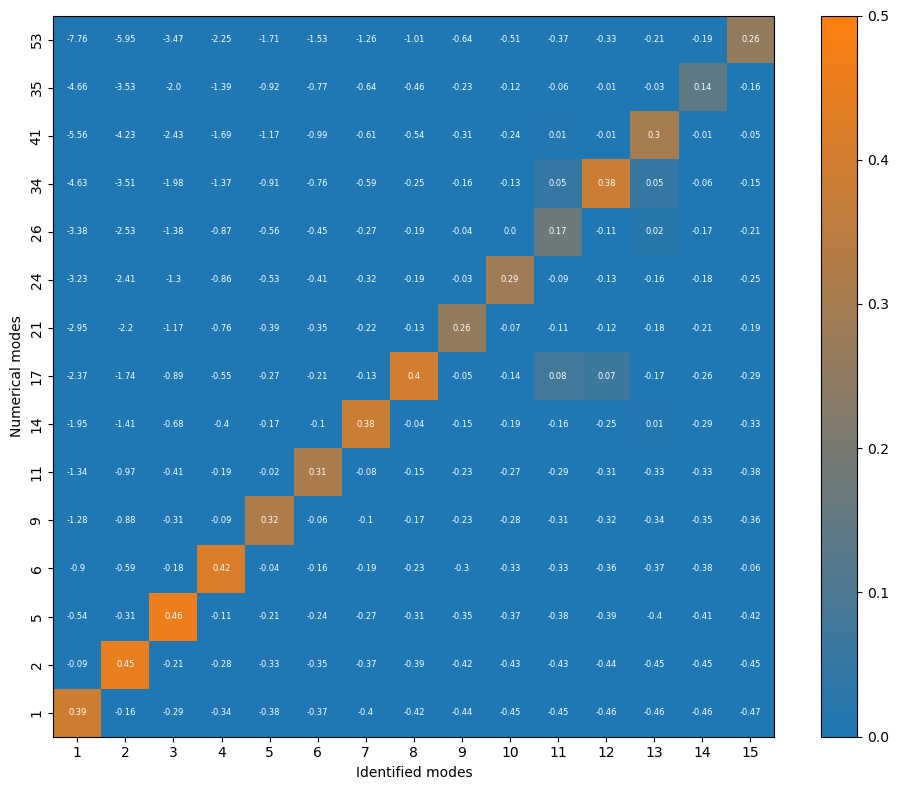

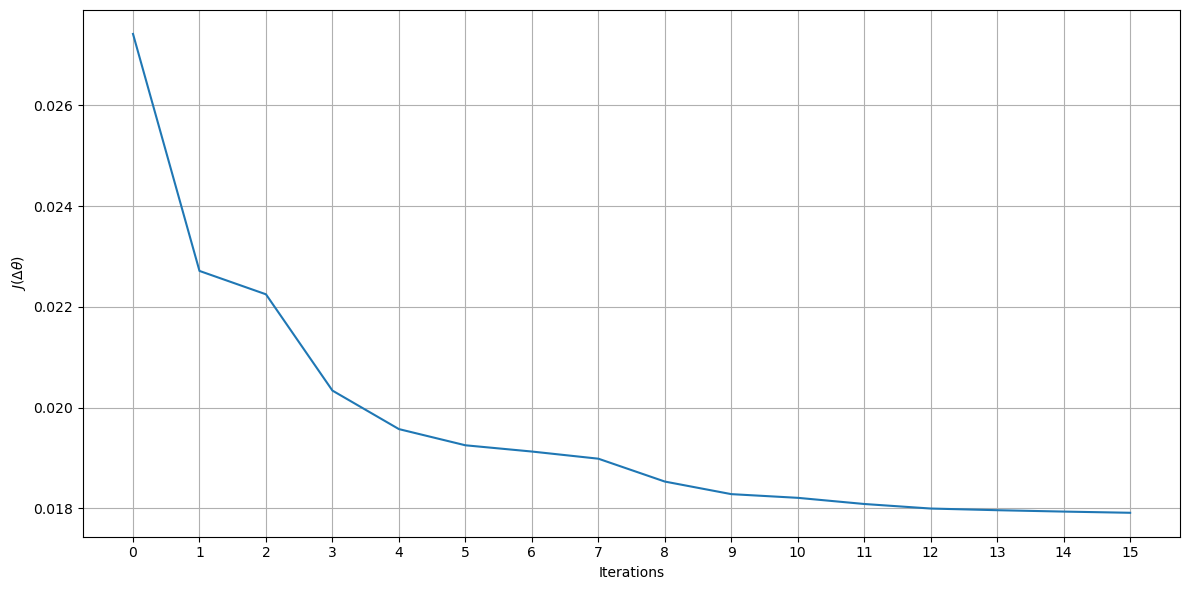

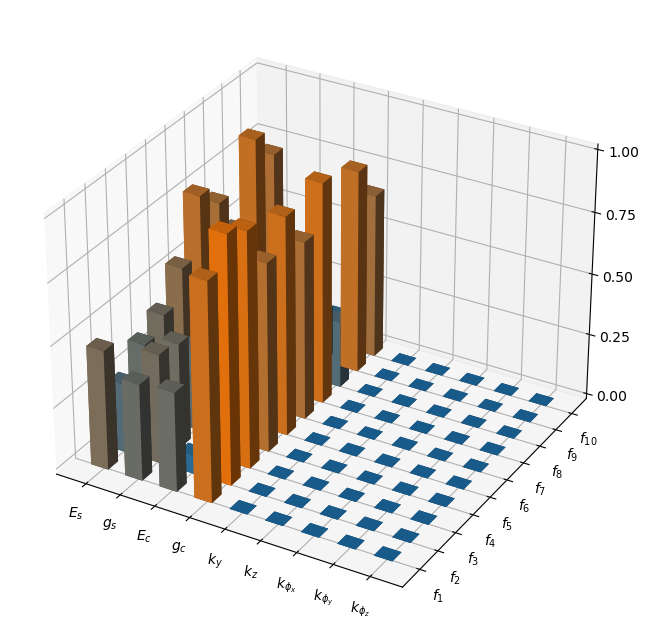

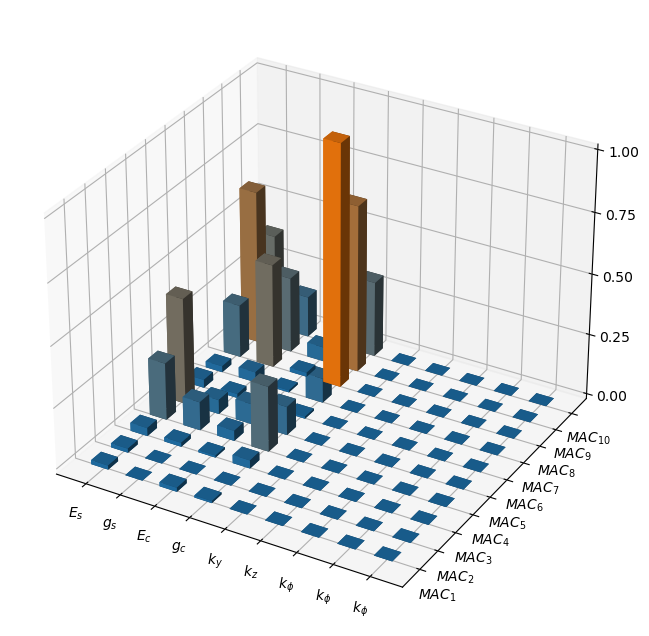

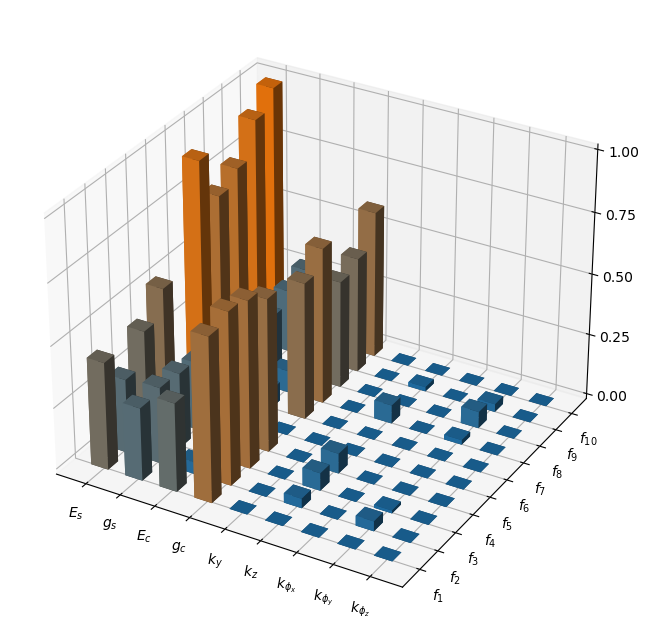

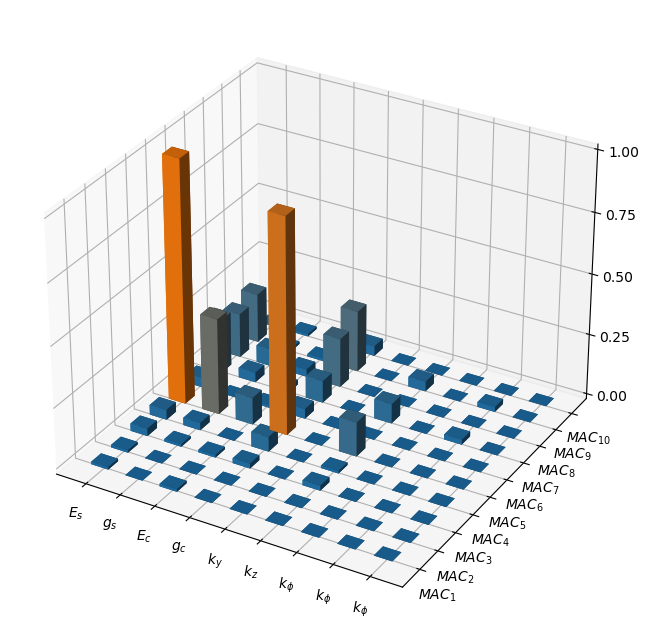

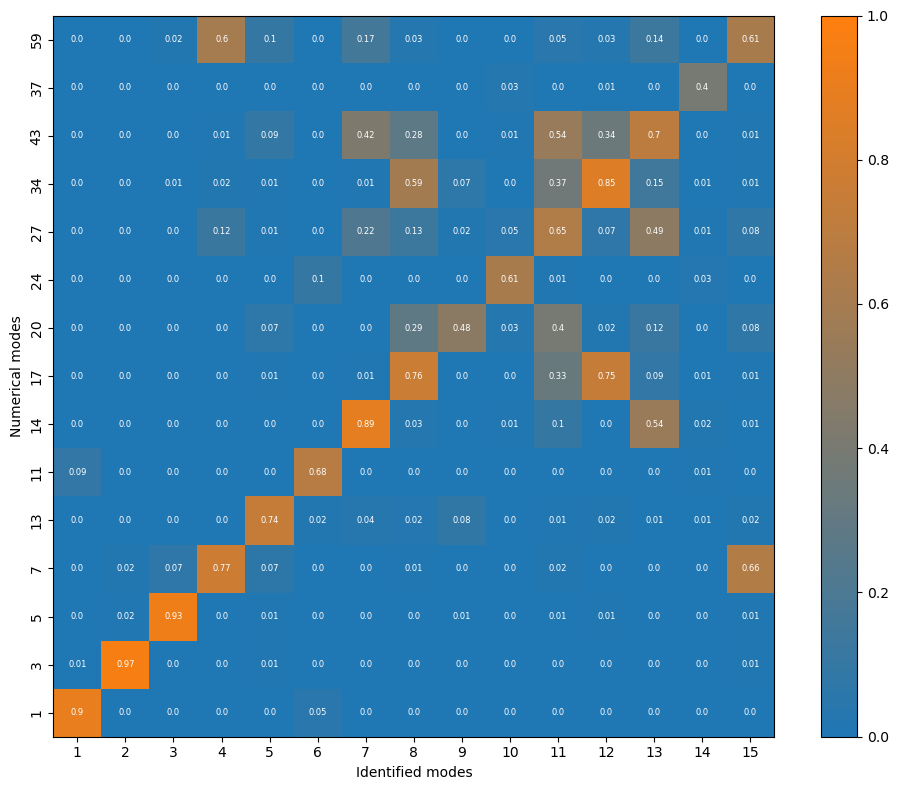

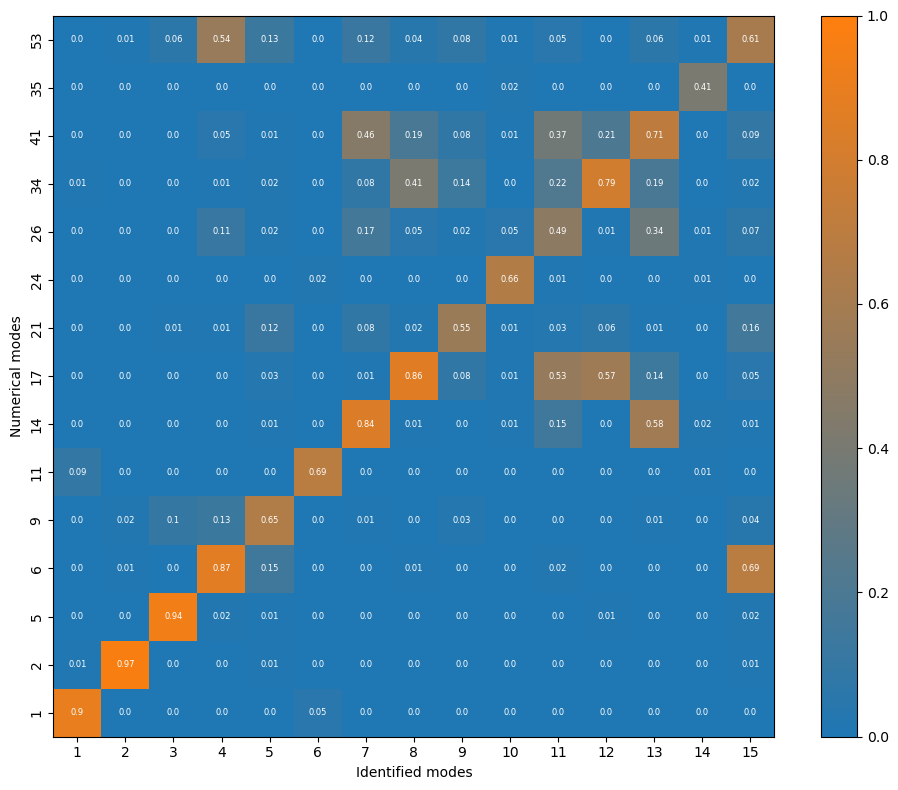

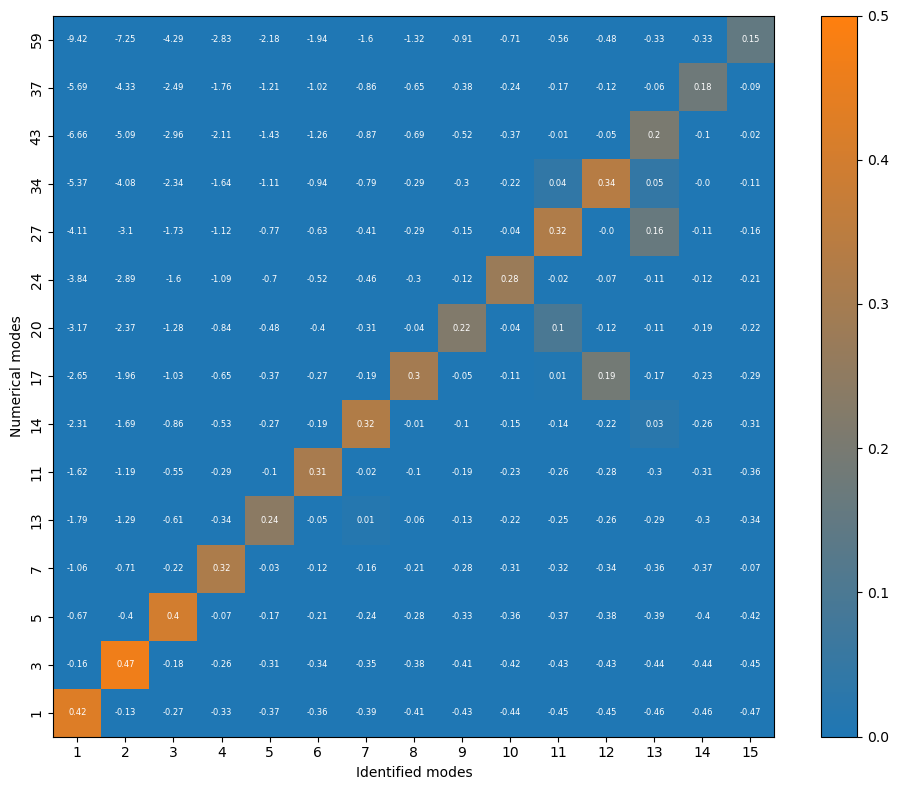

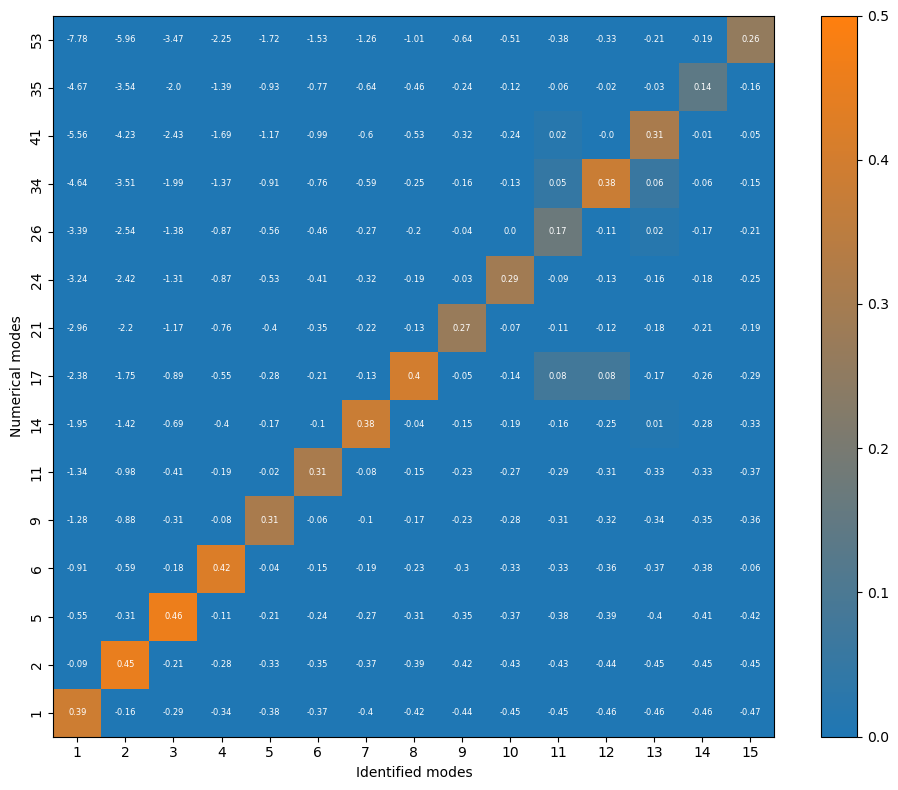

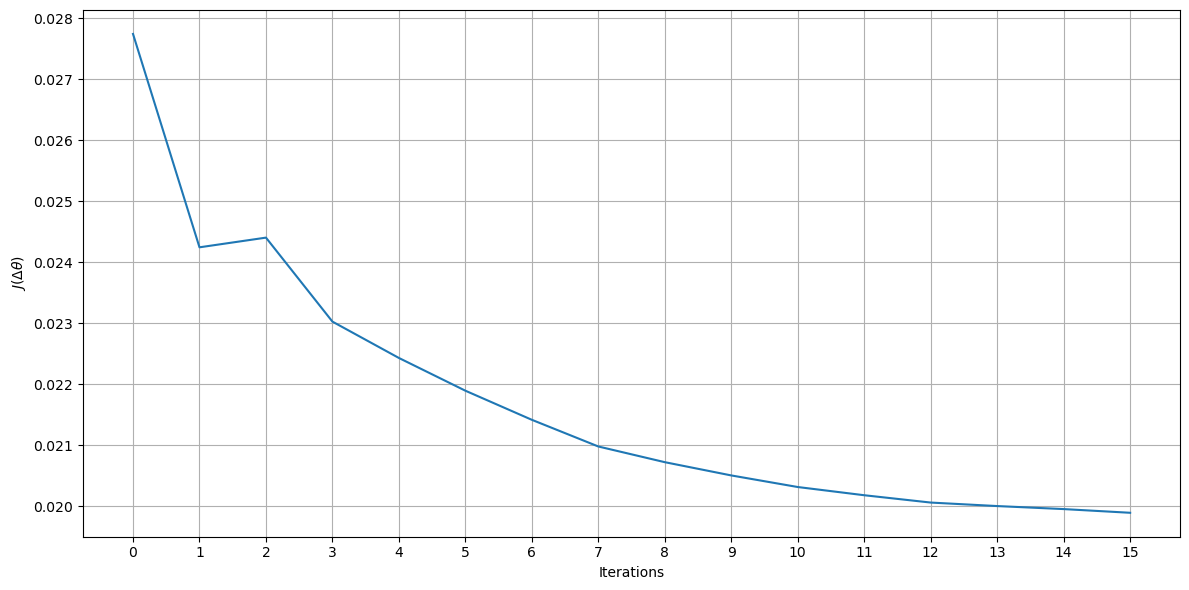

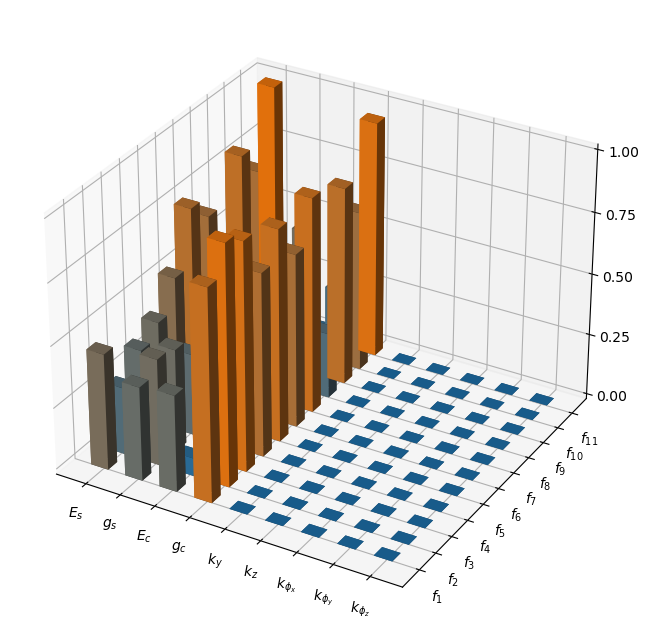

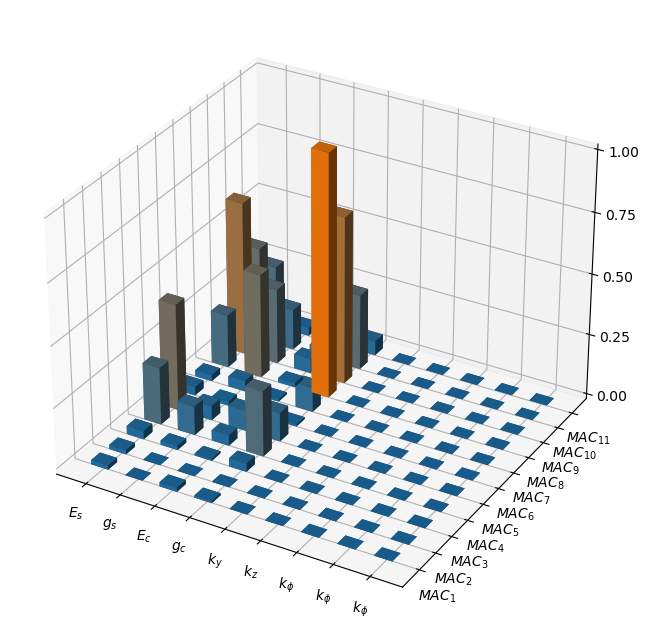

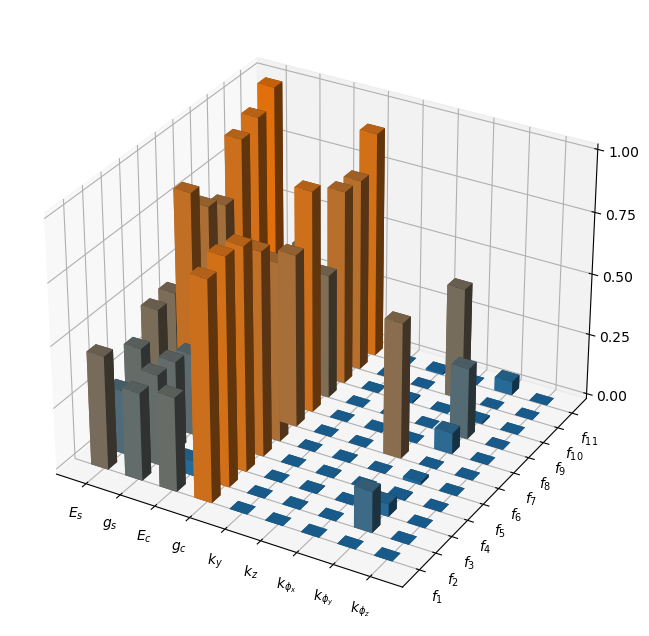

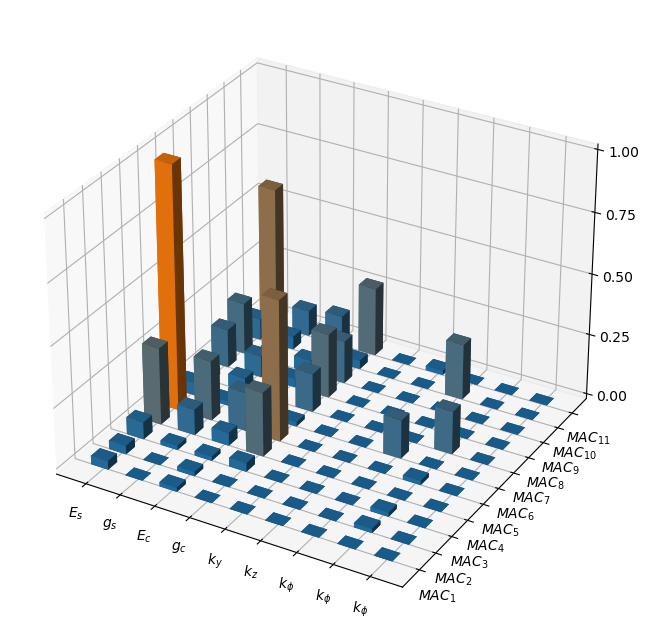

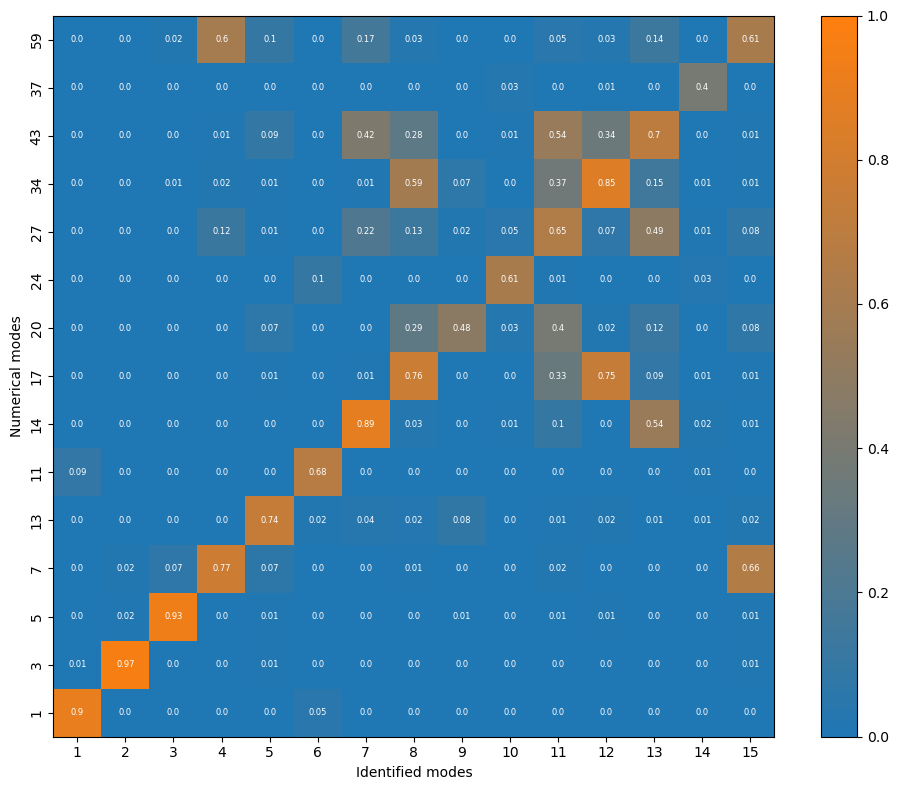

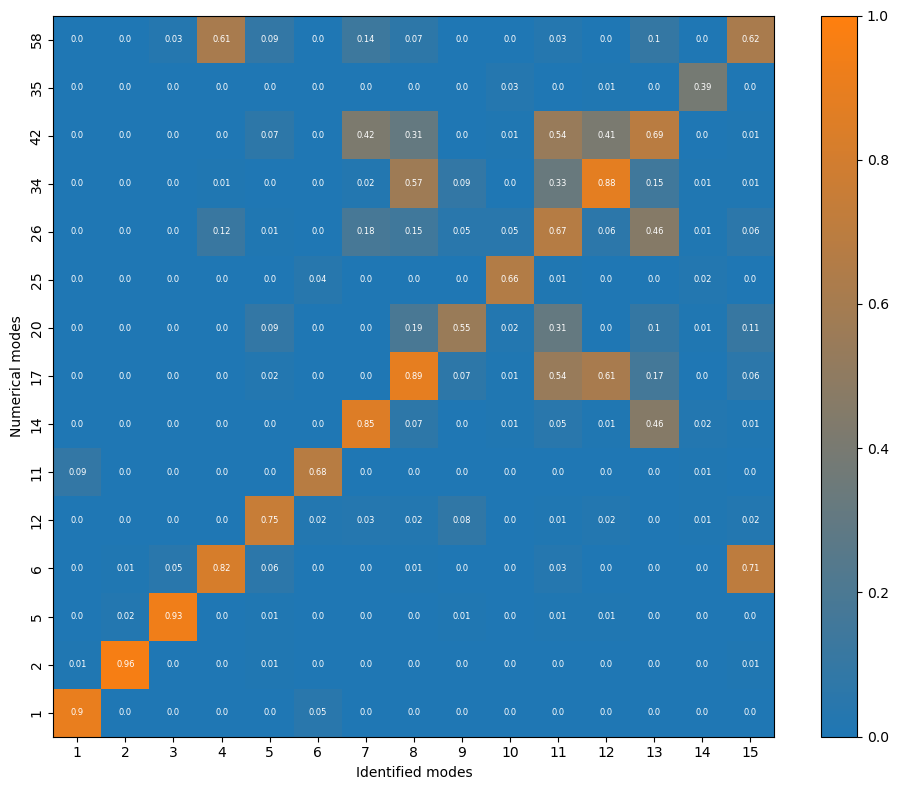

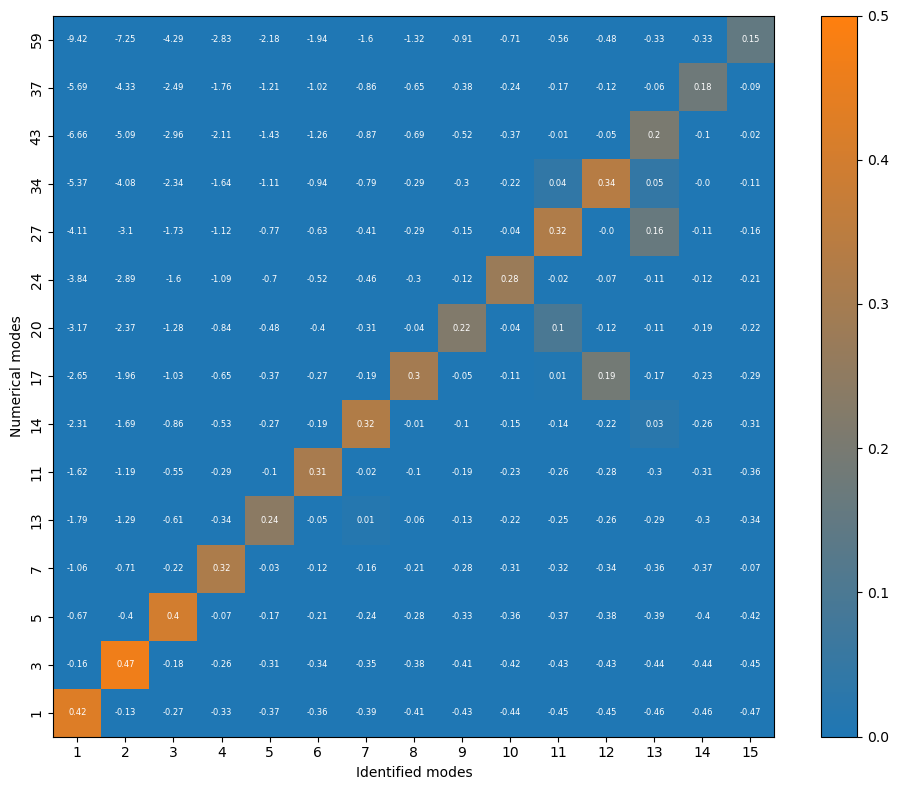

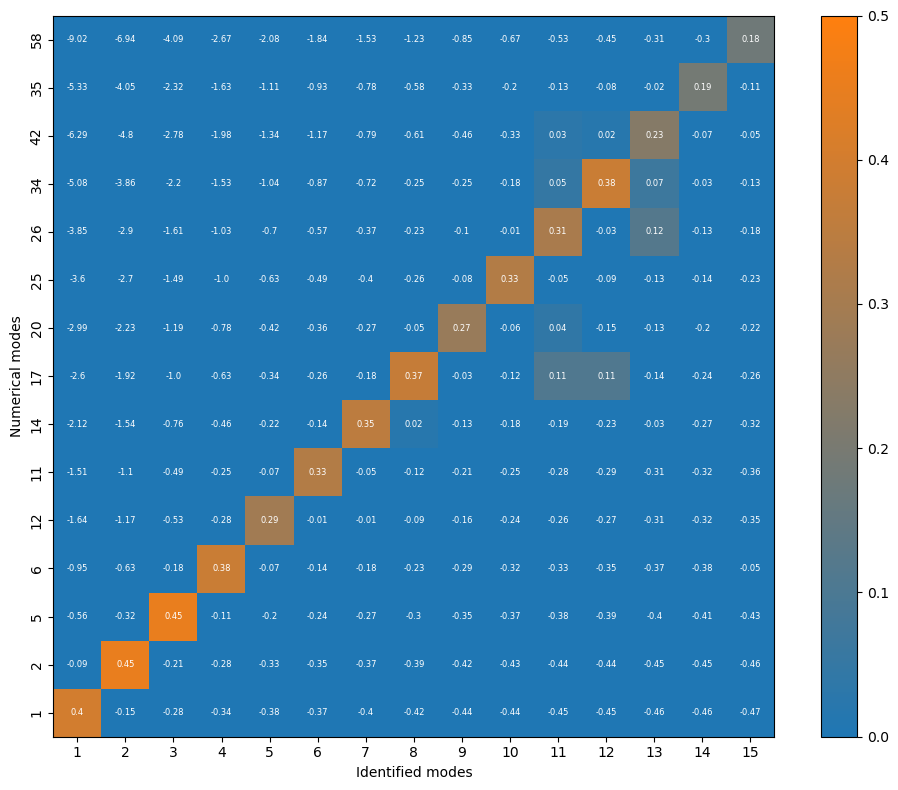

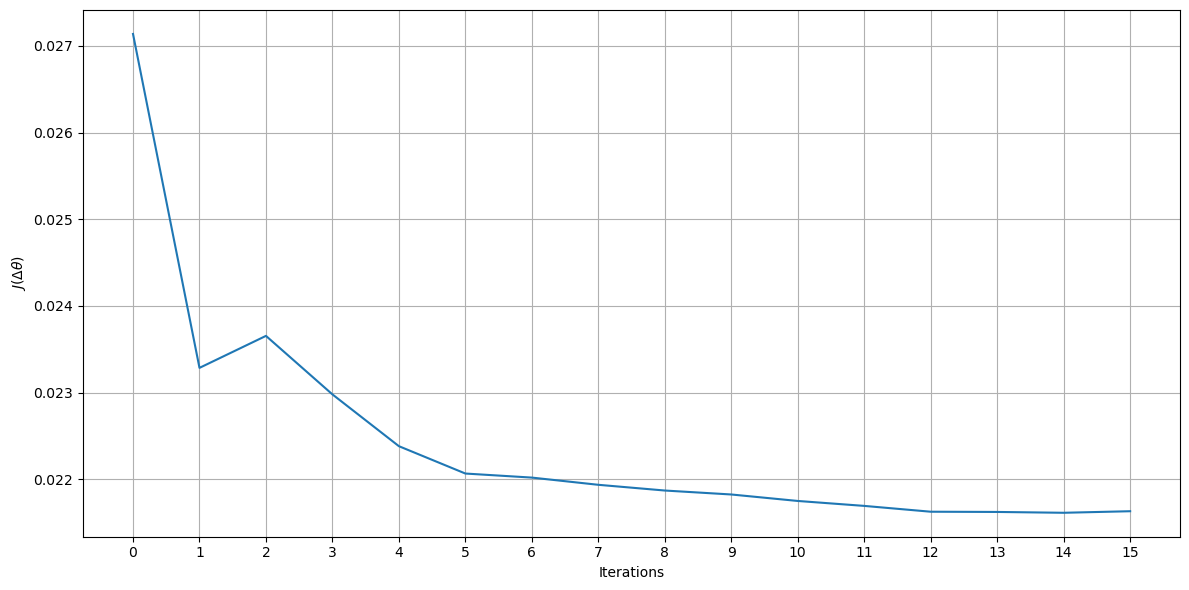

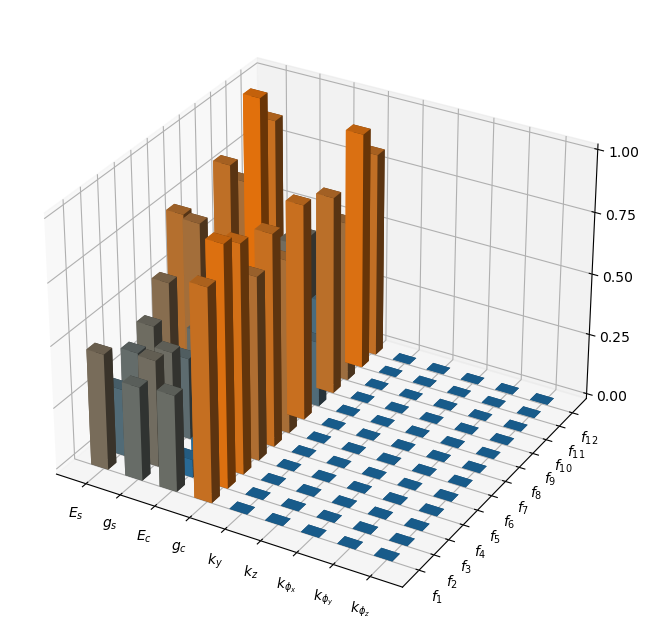

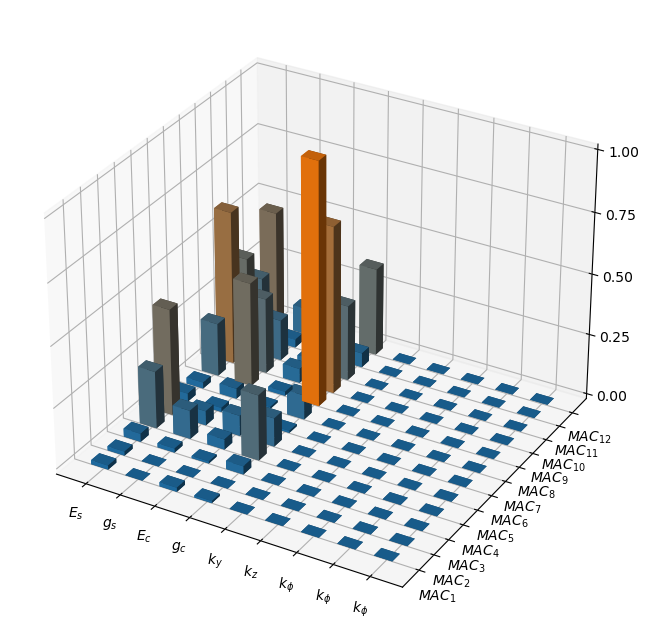

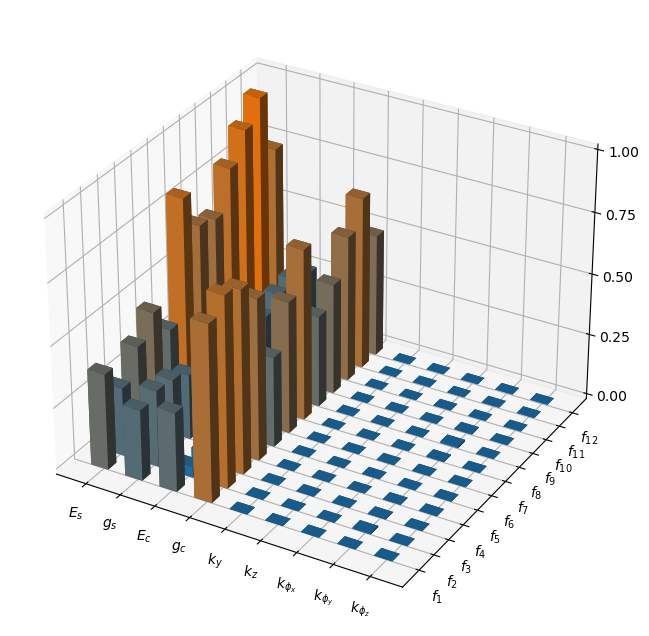

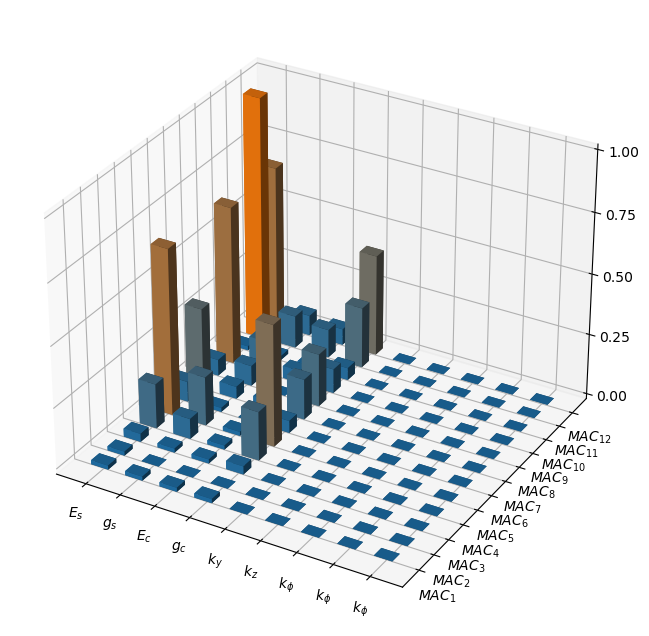

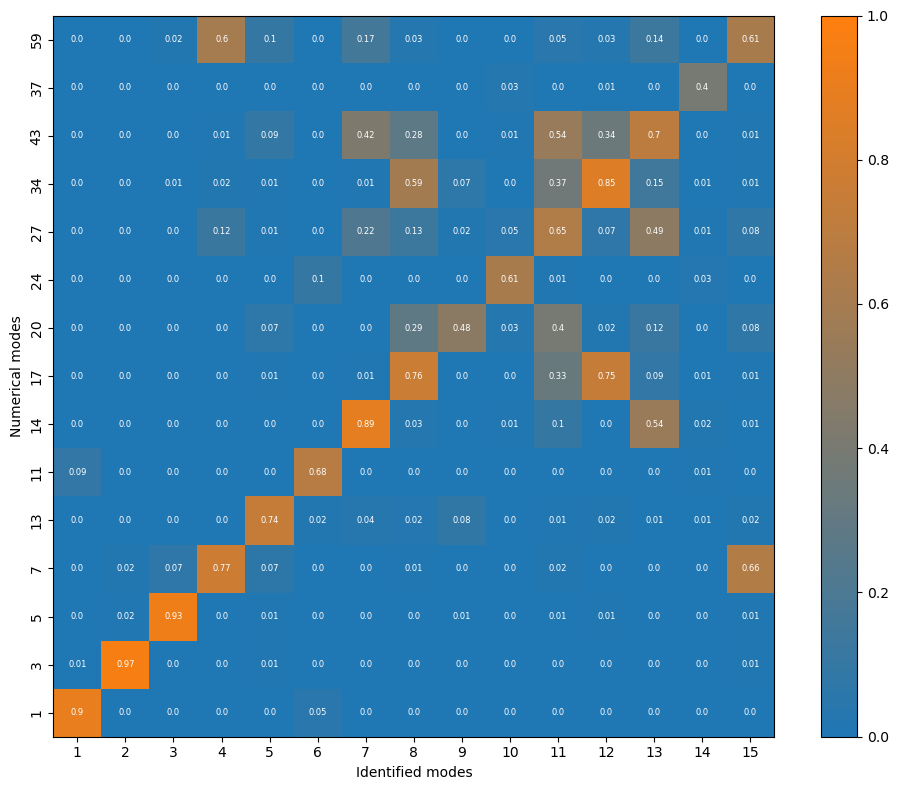

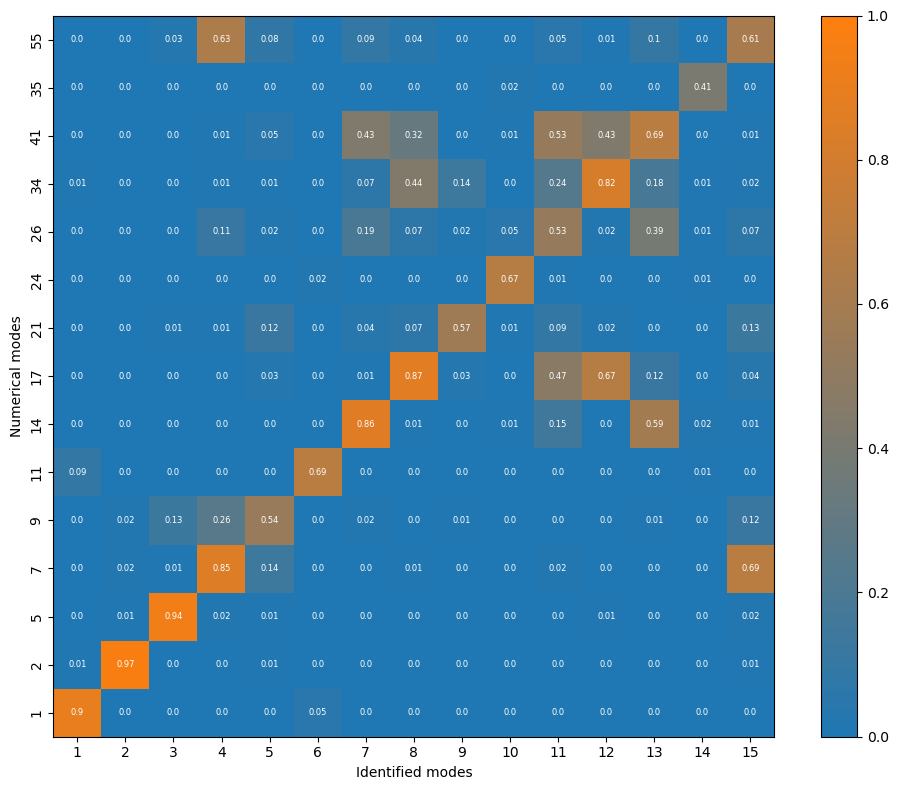

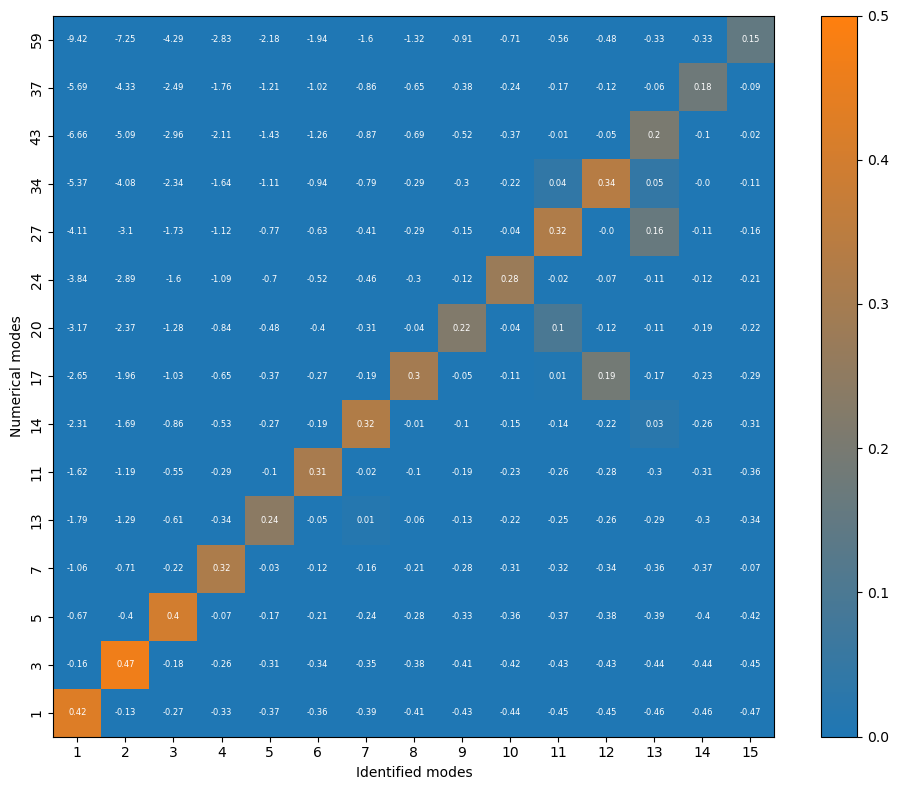

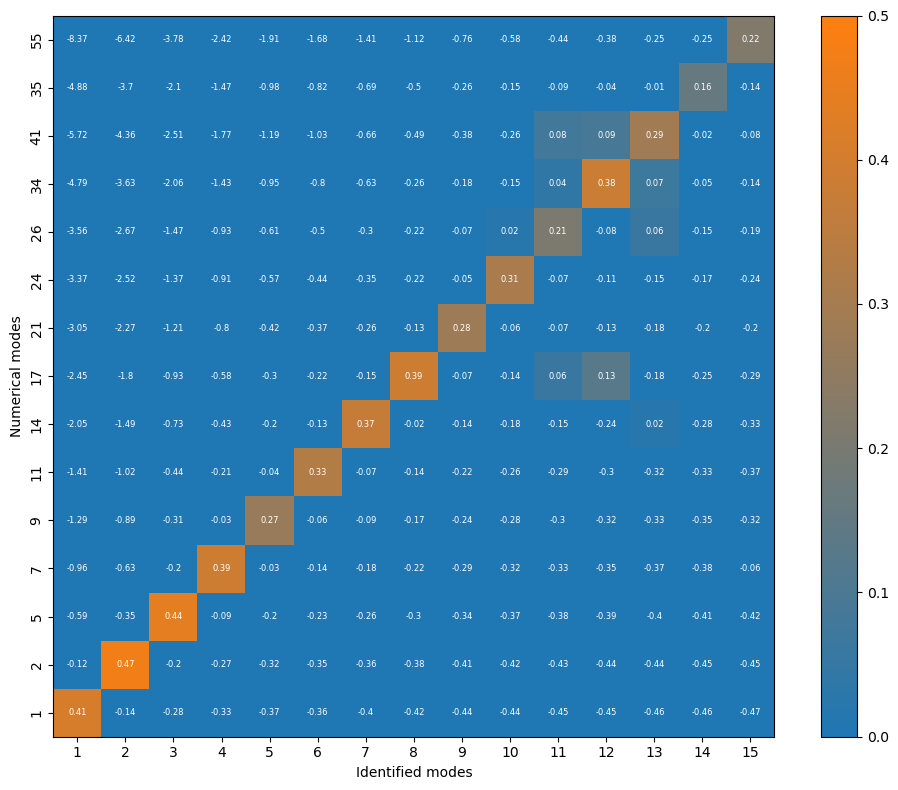

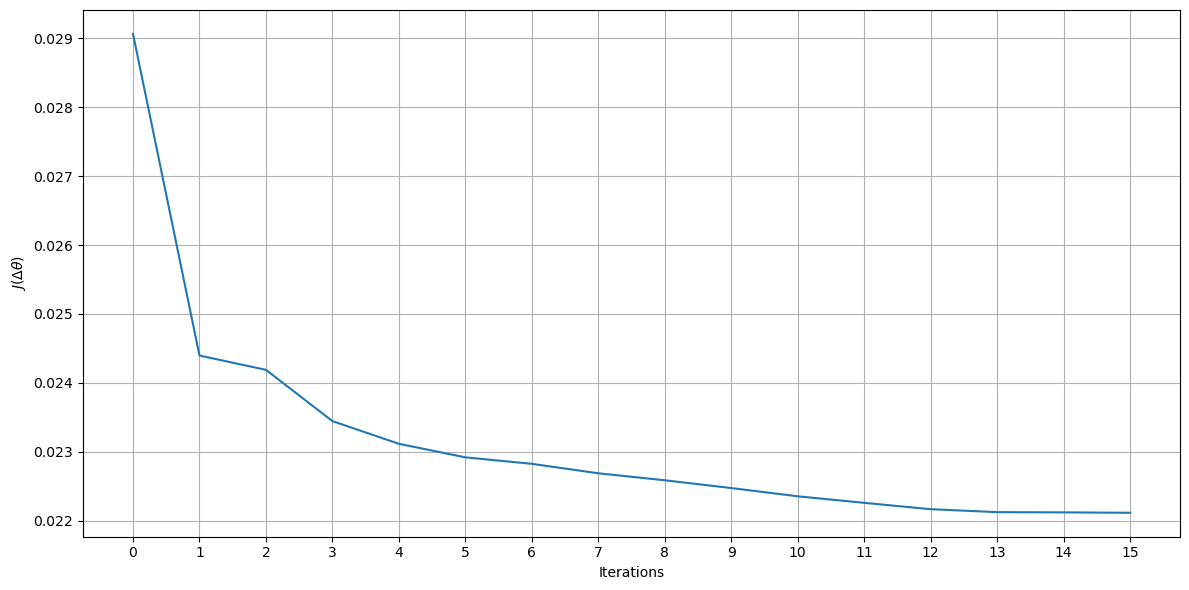

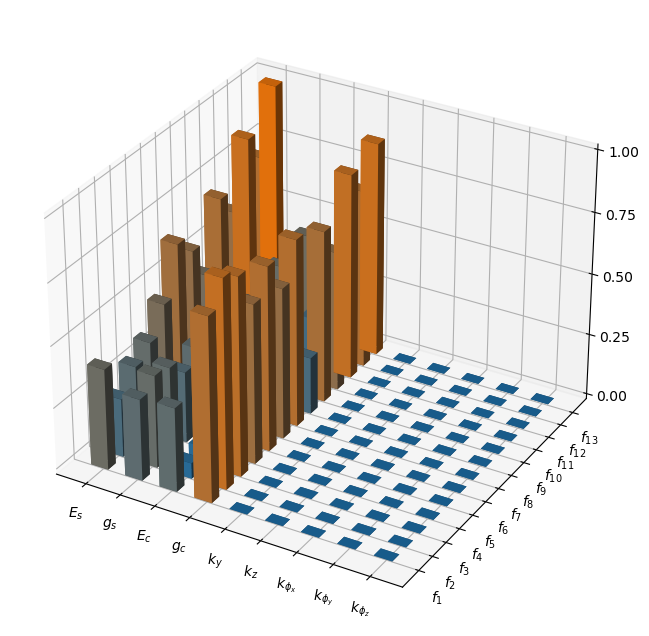

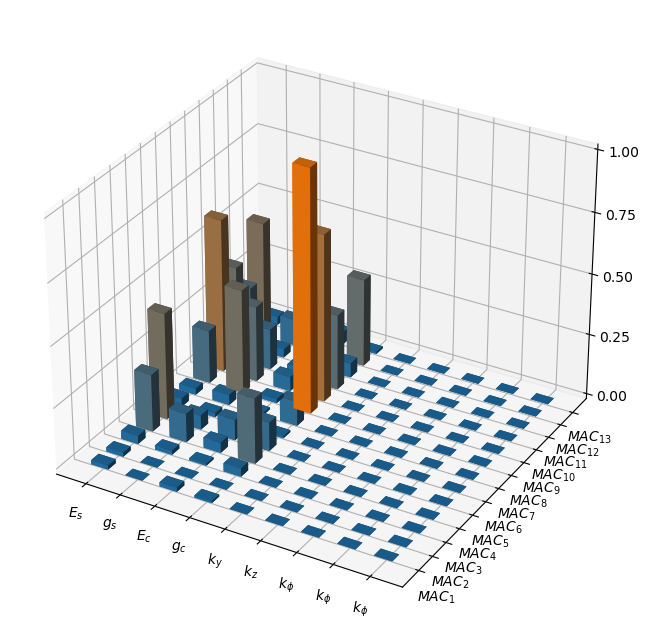

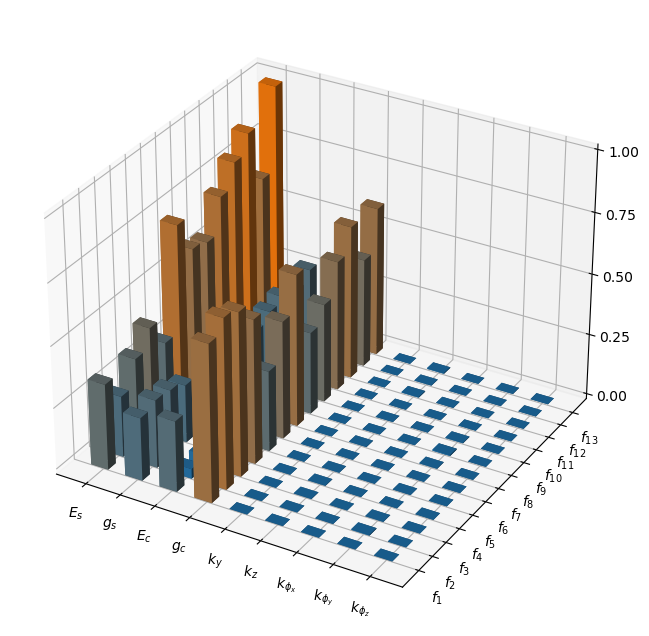

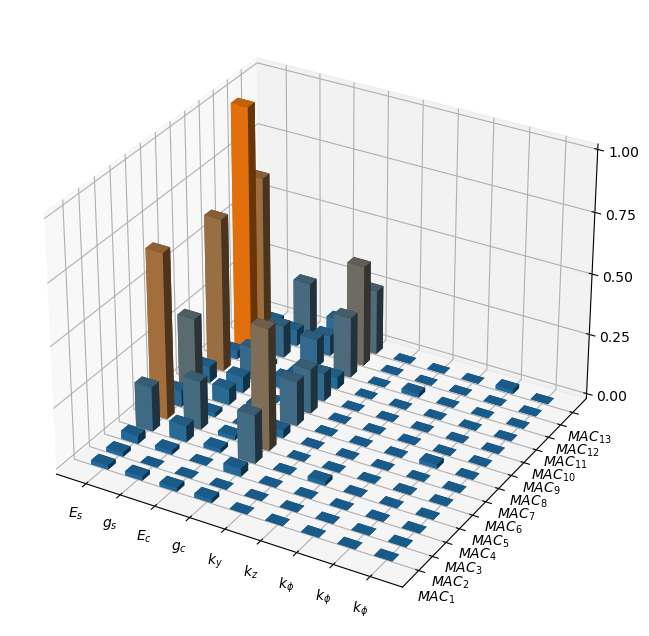

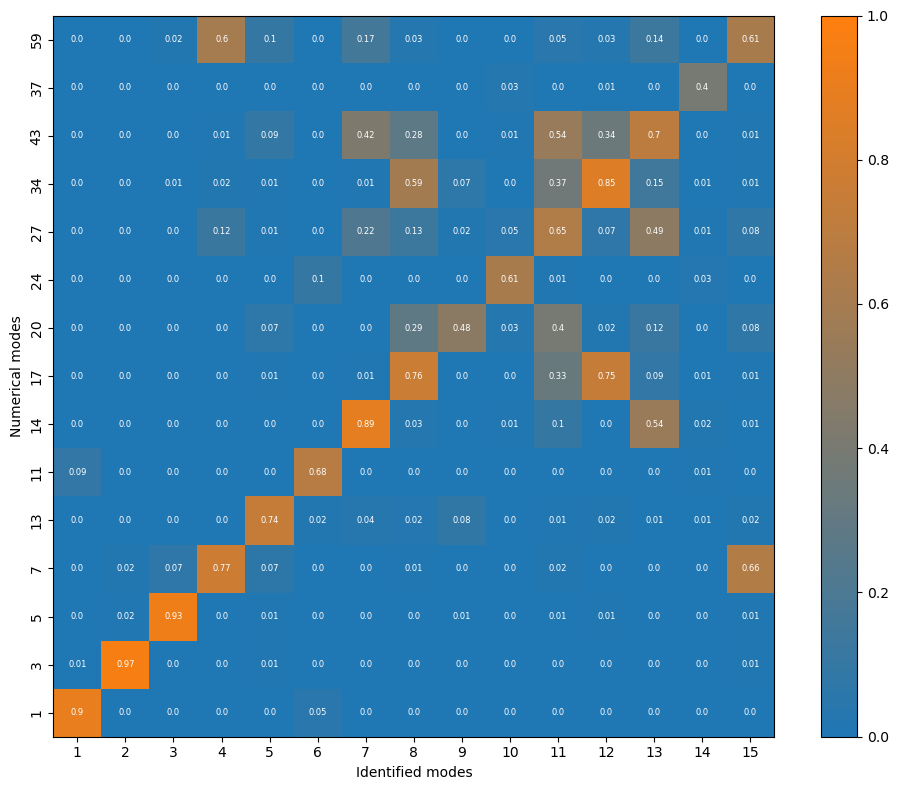

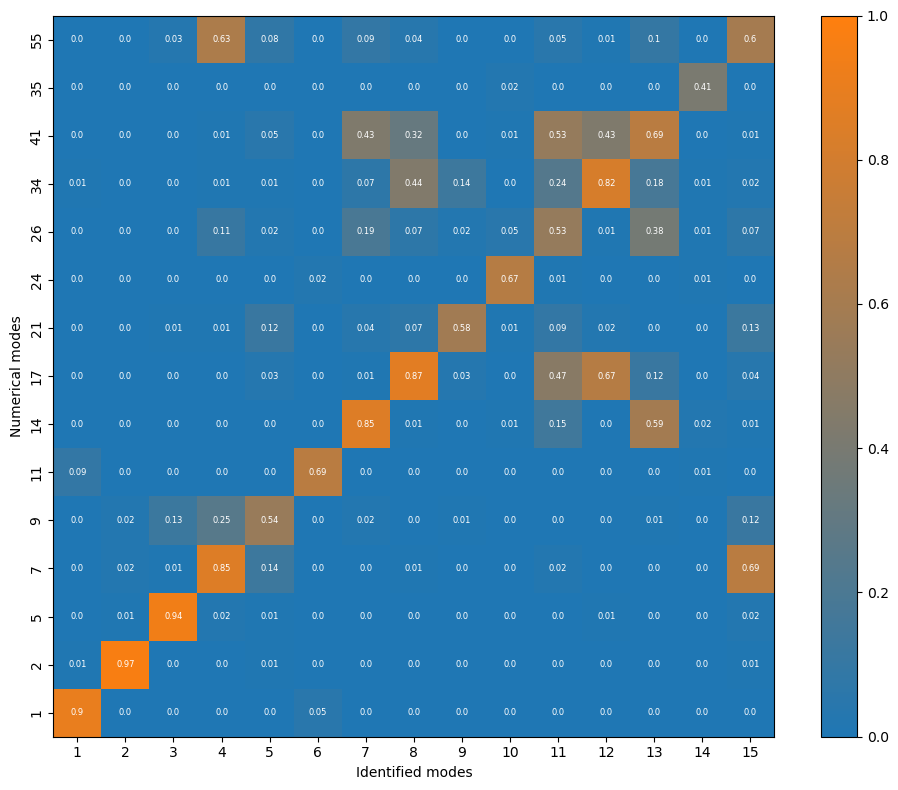

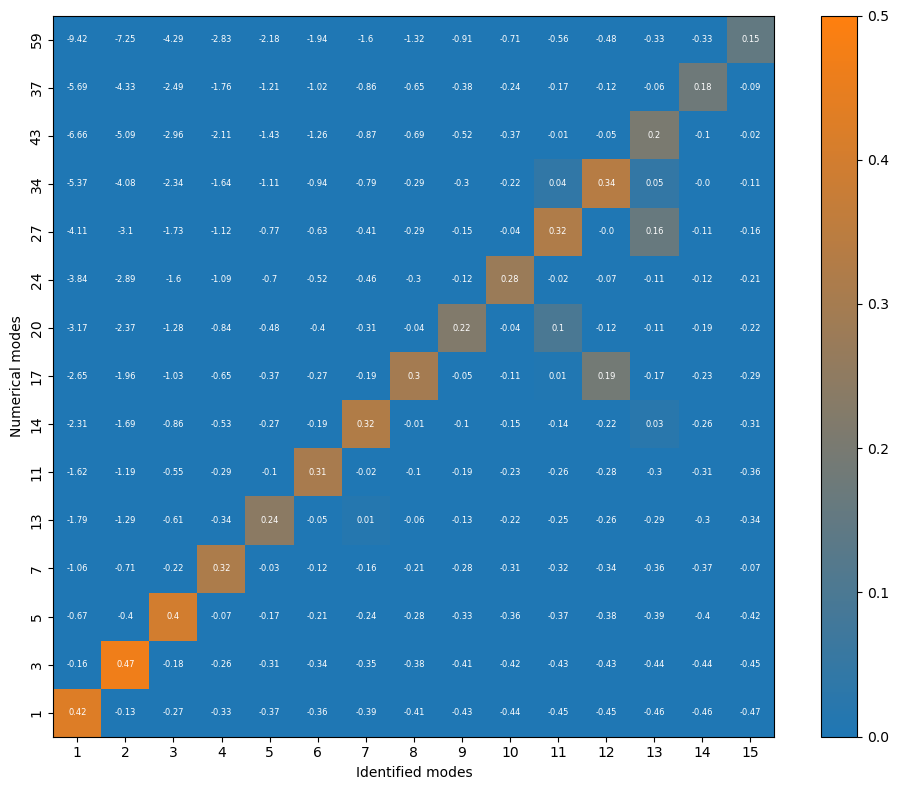

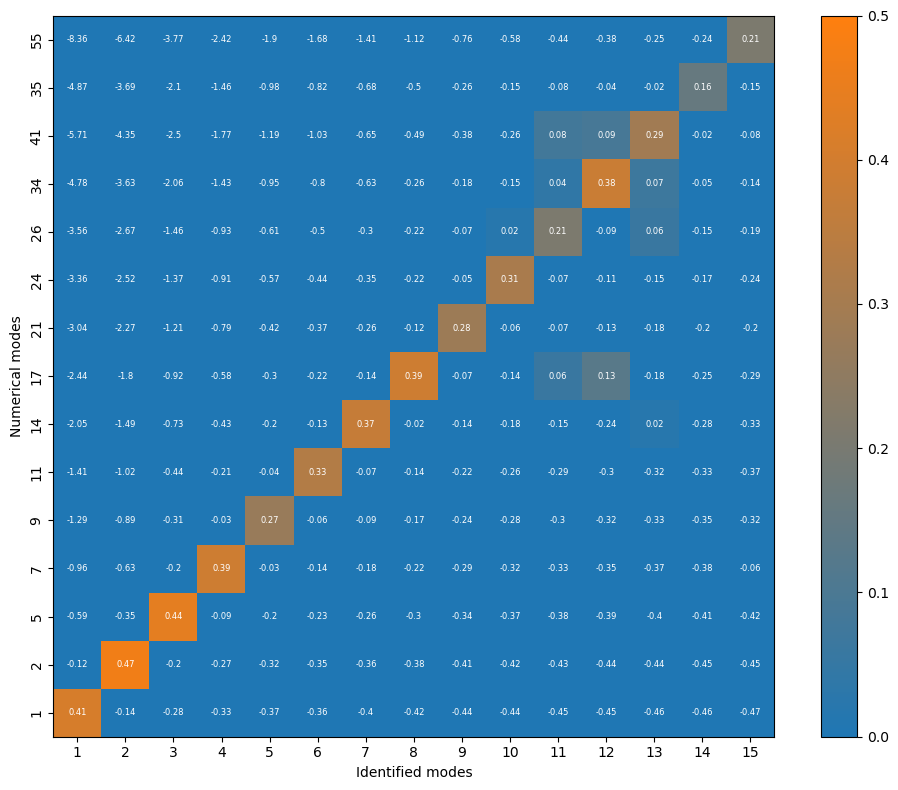

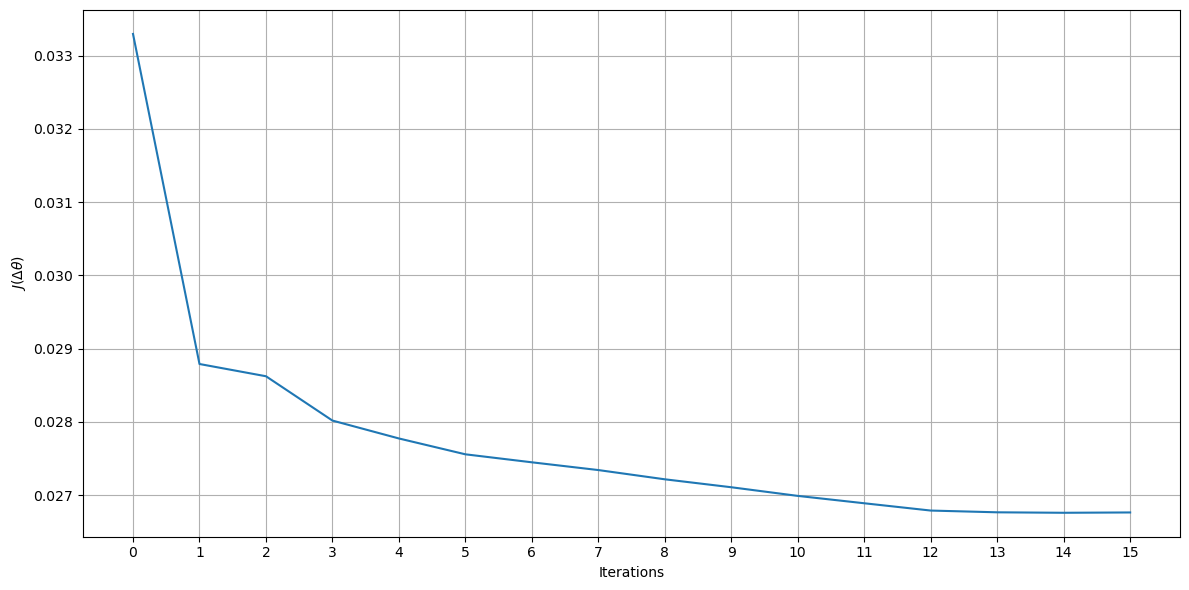

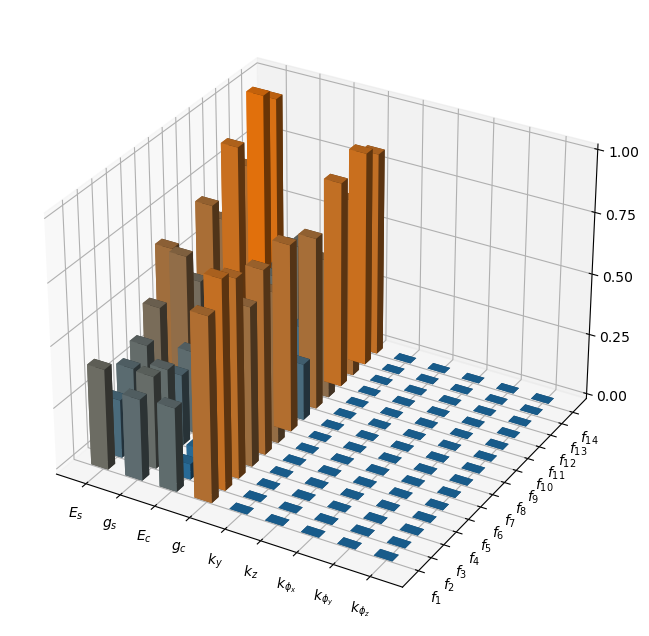

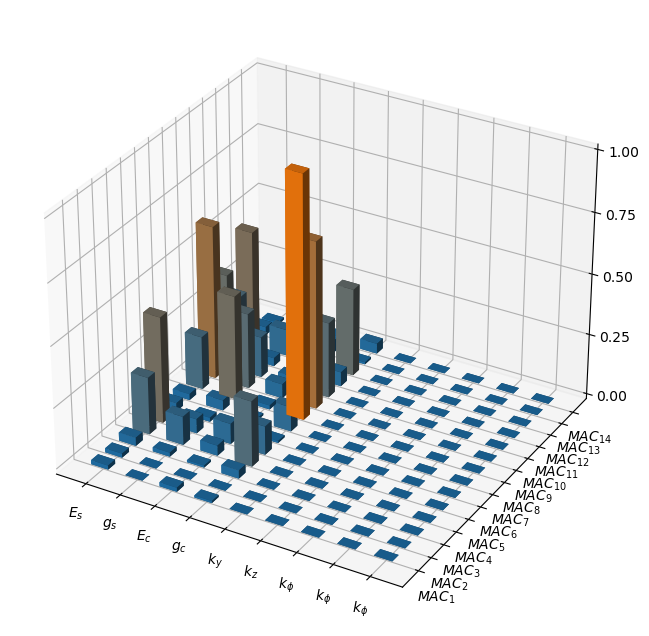

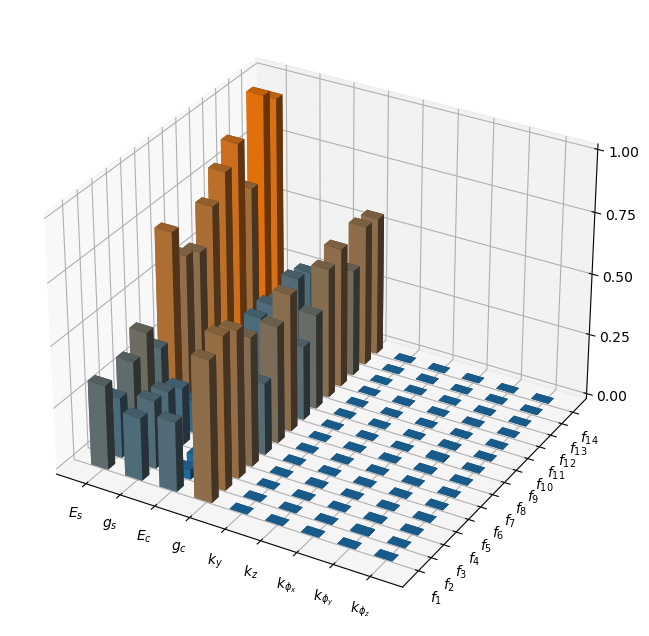

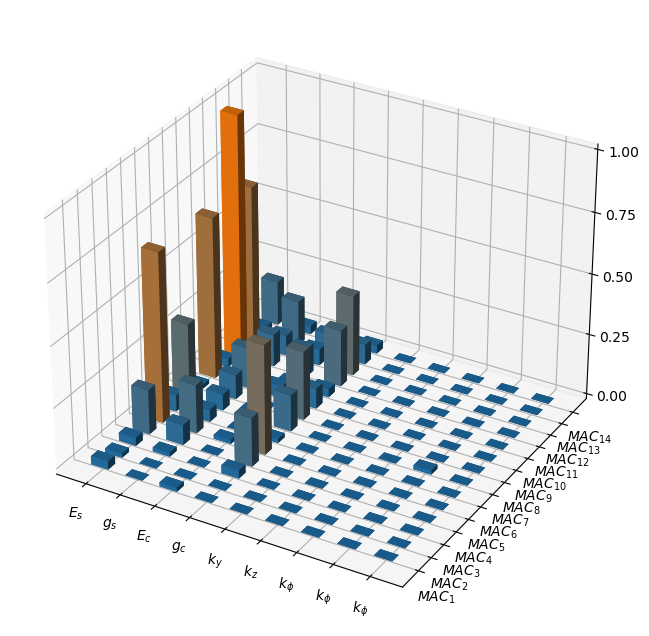

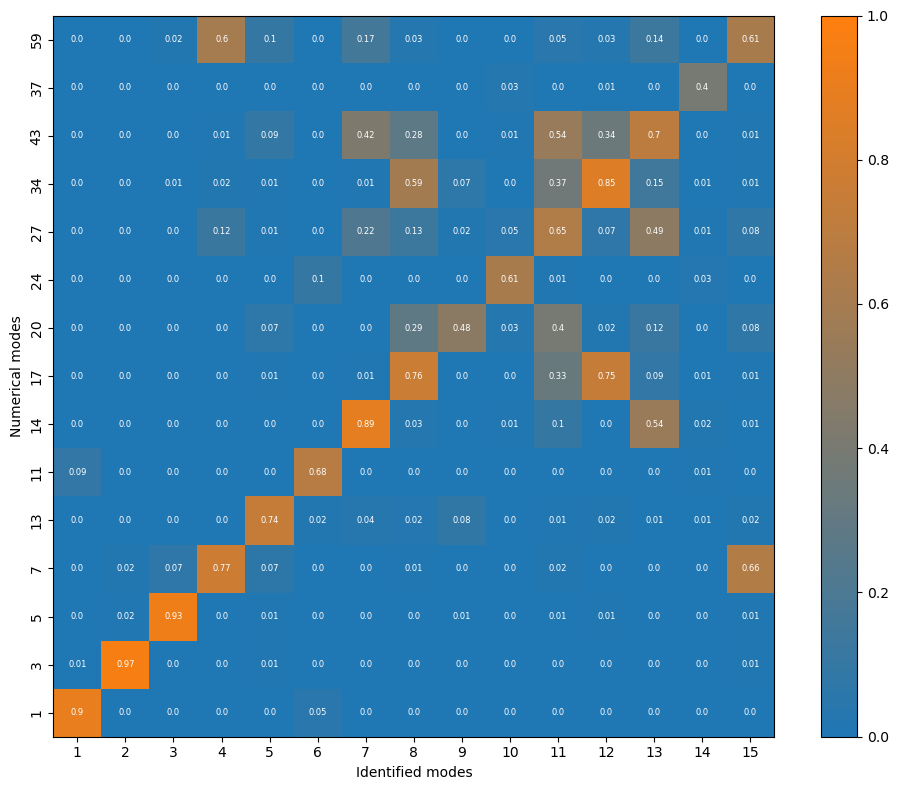

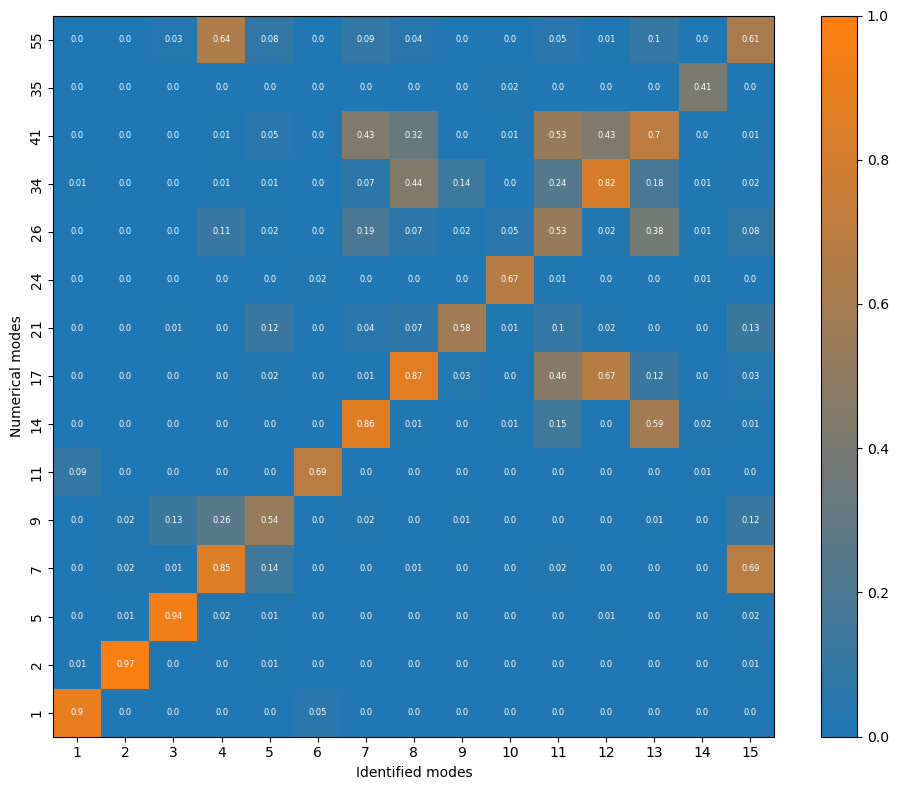

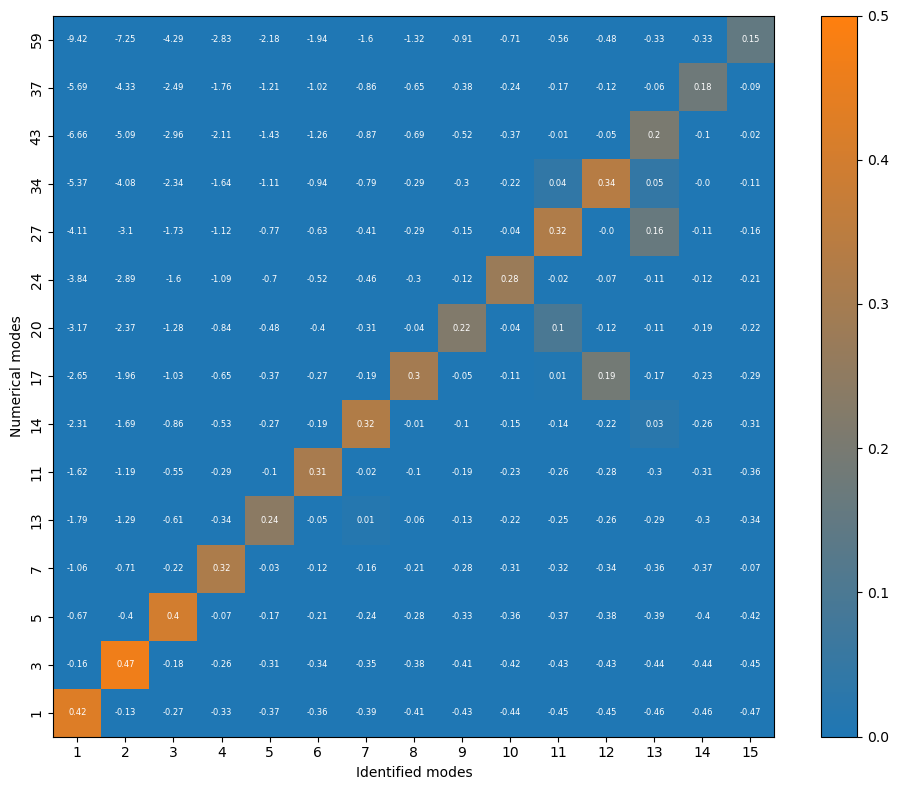

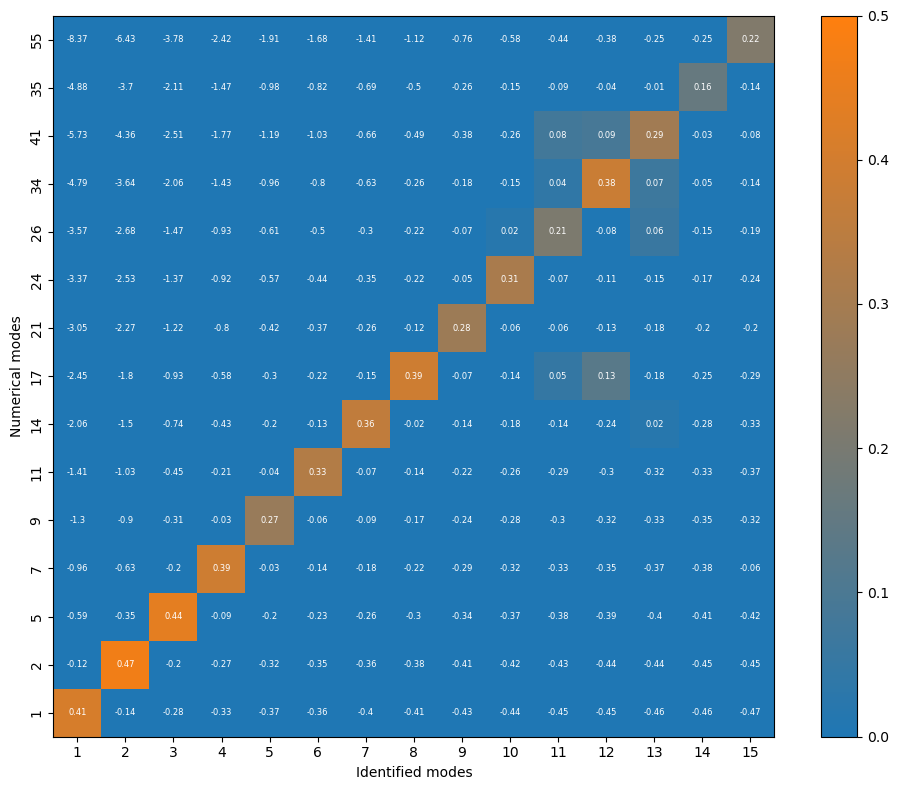

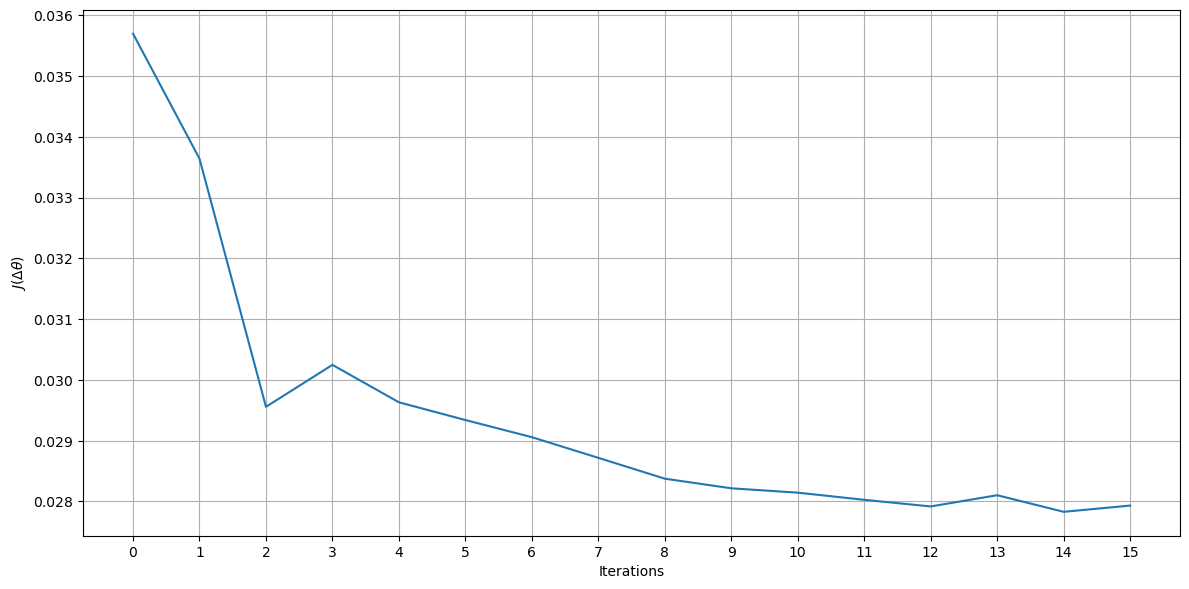

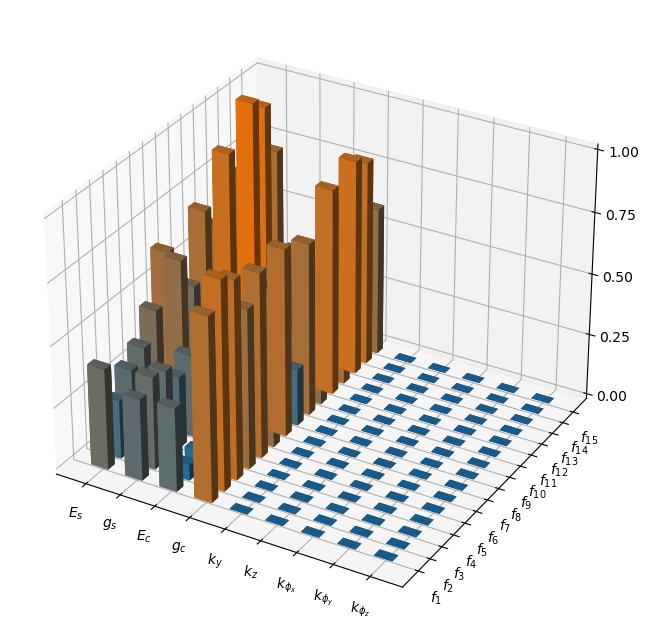

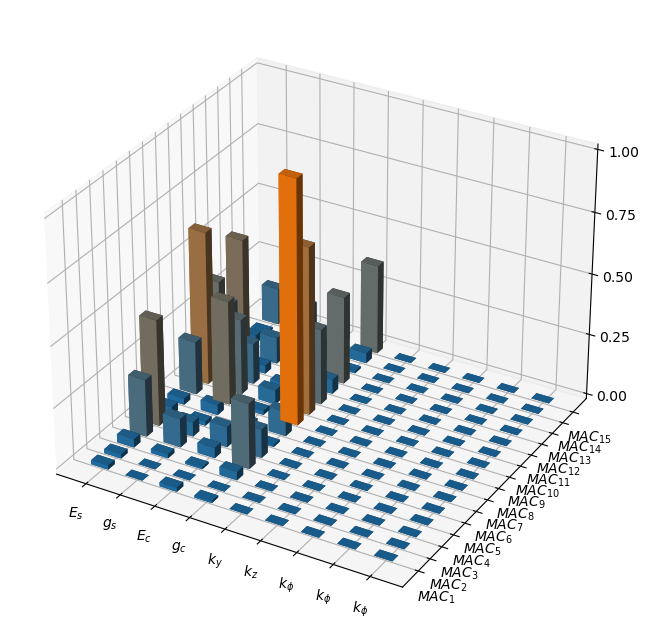

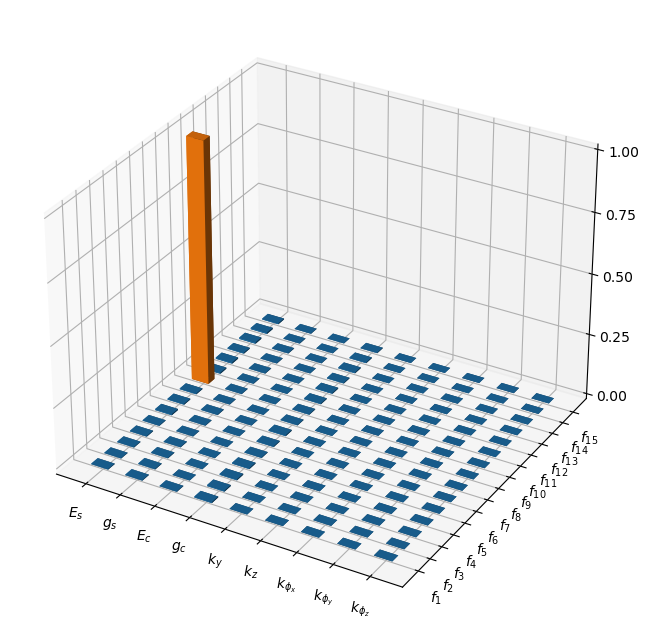

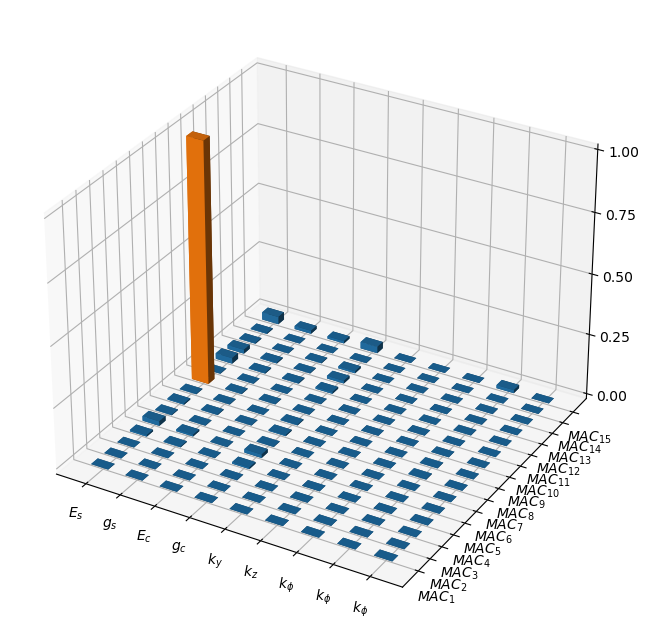

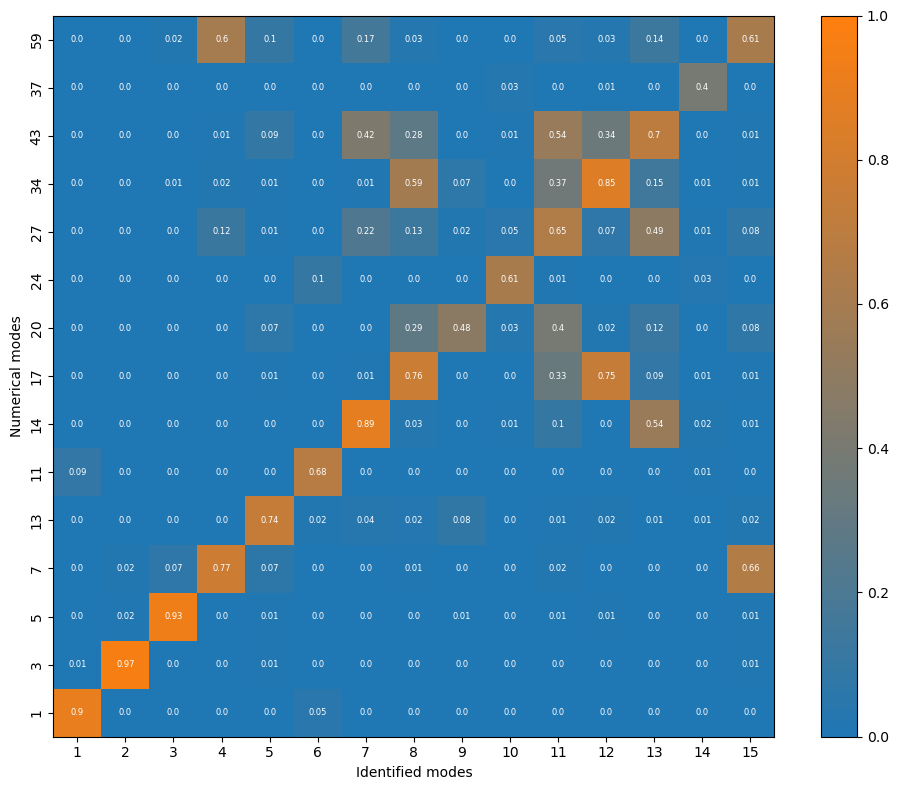

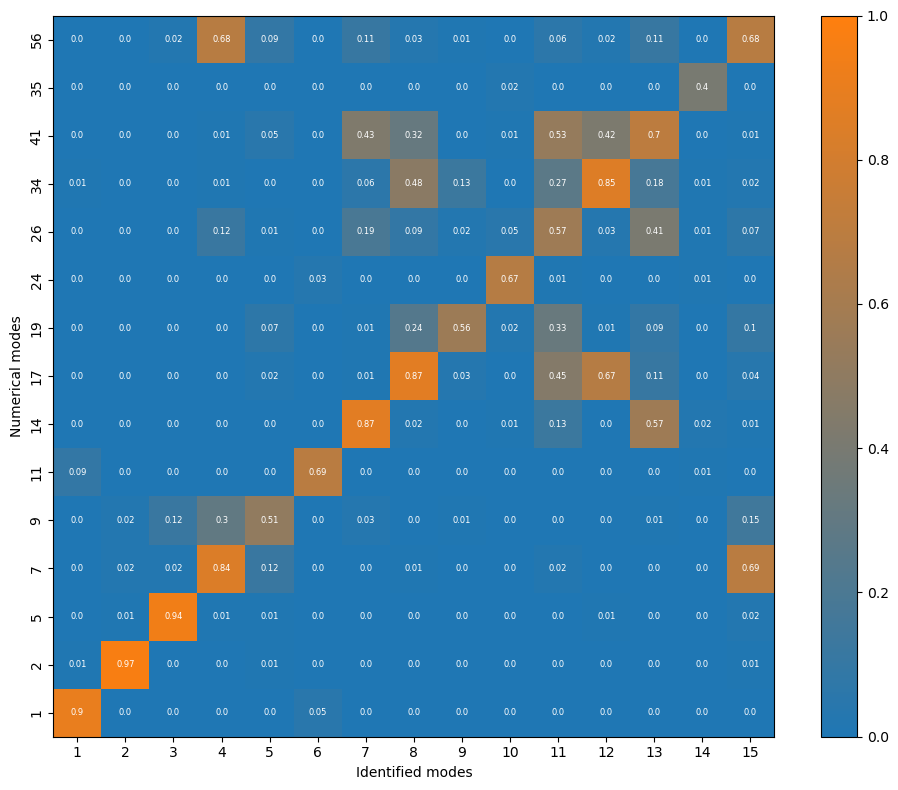

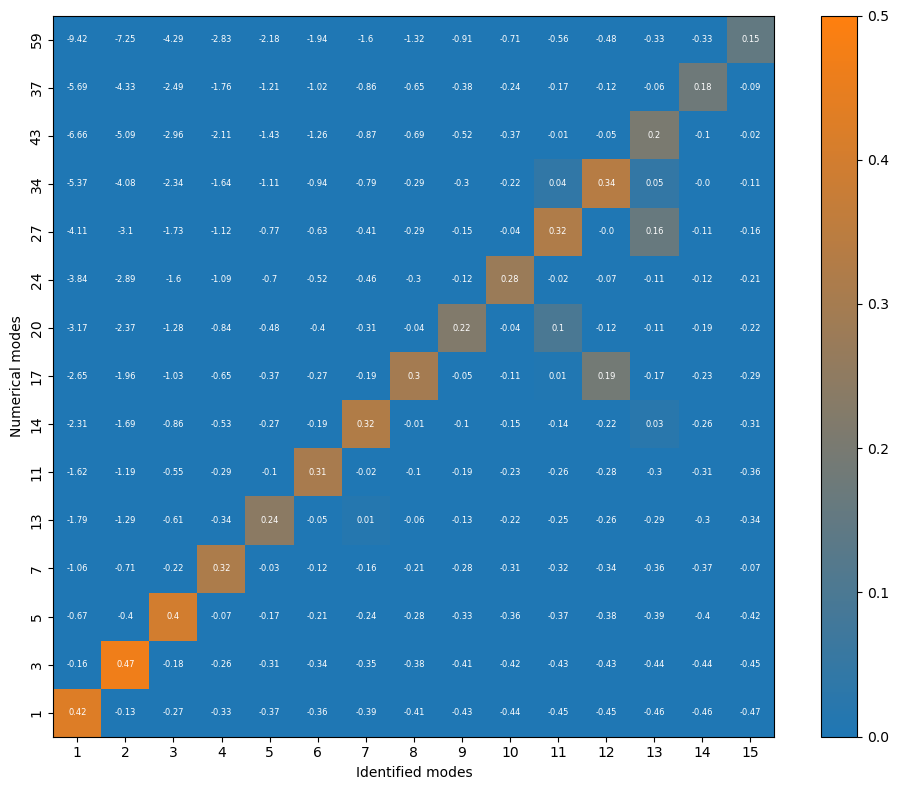

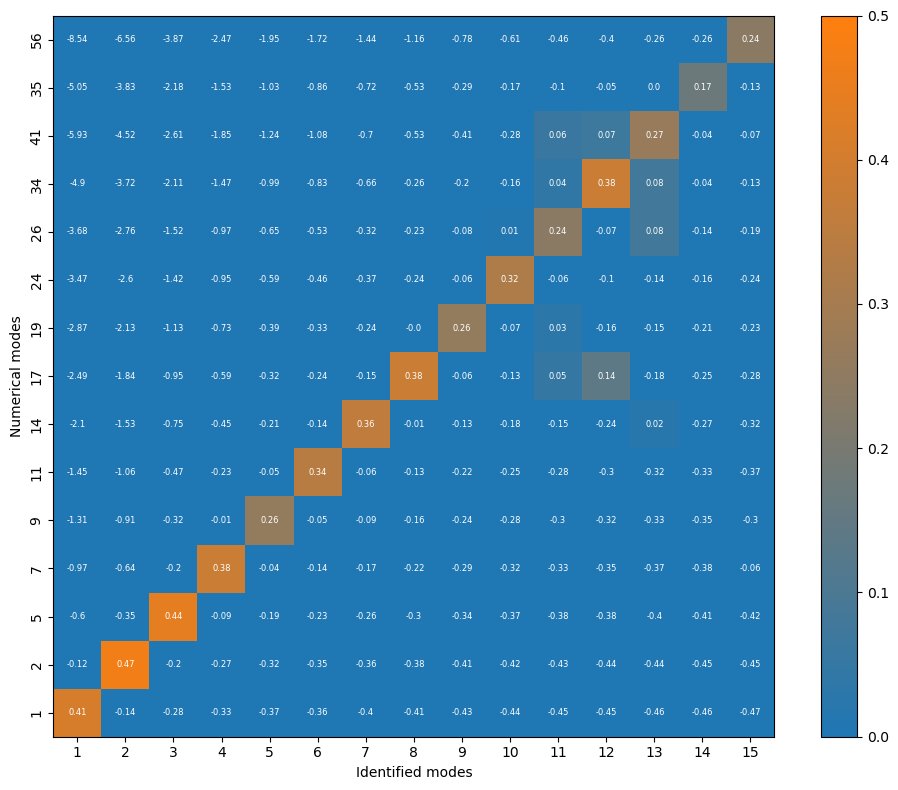

In [11]:
fig_format1 = ".png"
fig_format2 = ".svg"

#083370
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["C0", "C1"])

for analysis, iteration in enumerate(J_index):
    fig_folder = folder + analyses[analysis] + "/pictures/"

    # Matplotlib customization
    # plt.rcParams.update({'mathtext.fontset': 'stix'})
    # plt.rcParams.update({'font.size': 8})
    # plt.rcParams.update({'lines.linewidth': 0.75})
    # matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    # Objective function
    iterations = np.arange(0, len(info_files[analysis]['J_star_list']))

    plt.figure(analysis * 10 + 1, figsize=(12, 6))
    plt.plot(iterations, info_files[analysis]['J_star_list'])
    plt.xticks(iterations)
    plt.xlabel('Iterations')
    plt.ylabel(r'$J(\Delta\theta)$')
    plt.grid()
    plt.tight_layout()

    # Save
    plt.savefig(fig_folder + 'objective_function' + fig_format1)
    plt.savefig(fig_folder + 'objective_function' + fig_format2)

    # Initial sensitivity matrix - Natural frequencies

    # Normalize
    G = np.abs(info_files[analysis]['G_matrices']['G1'])
    # G = G / np.amax(G)
    rows, cols = np.shape(G)
    G[0:int(rows/2),:] = G[0:int(rows/2),:] / np.amax(G[0:int(rows/2),:])
    G[int(rows/2):,:] = G[int(rows/2):,:] / np.amax(G[int(rows/2):,:])

    # 3D plot
    fig = plt.figure(analysis * 10 + 2, figsize=(10, 8))
    ax = plt.axes(projection='3d')
    # ax.set_title('Initial sensitivity matrix (Natural frequencies)', fontweight='bold')

    for j in range(int(rows/2)):

        # Centering of the bars
        dx = 0.25
        dy = 0.25

        # Coordinates of the bars
        x = []
        y = []
        z = np.zeros(len(info_files[analysis]["theta"][0]))

        # Size of the bars 
        dx_vec = []
        dy_vec = []
        dz_vec = G[j, :]

        for i in range(len(info_files[analysis]["theta"][0])):
            x.append(i - dx)
            y.append(j - dy)

            dx_vec.append(0.5)
            dy_vec.append(0.5)
        
        # Colormap
        cmap_alt1 = plt.cm.viridis(dz_vec)
        cmap_alt2 = plt.cm.rainbow(dz_vec)

        # Plot
        bar1 = ax.bar3d(x, y, z, dx_vec, dy_vec, dz_vec, color=custom_cmap(dz_vec),
                        zsort='max', alpha=1.0)

    ax.set_xticks([i for i in range(len(info_files[analysis]["theta"][0]))])
    ax.set_xticklabels([r'$E_s$', r'$g_s$', r'$E_c$', r'$g_c$', r'$k_y$', r'$k_z$', 
                        r'$k_{\phi_x}$', r'$k_{\phi_y}$', r'$k_{\phi_z}$'])
    ax.set_yticks([i for i in range(int(rows/2))])
    ax.set_yticklabels([f"$f_\u007b{i+1}\u007d$" for i in range(int(rows/2))])
    ax.set_zticks([0, 0.25, 0.5, 0.75, 1.0])

    # Save
    plt.savefig(fig_folder + 'initial_sensitivity_matrix_freq' + fig_format1)
    plt.savefig(fig_folder + 'initial_sensitivity_matrix_freq' + fig_format2)

    # Initial sensitivity matrix - Mode shapes

    fig = plt.figure(analysis * 10 + 3, figsize=(10, 8))
    ax = plt.axes(projection='3d')
    # ax.set_title('Initial sensitivity matrix (Mode shapes)', fontweight='bold')

    for j in range(int(rows/2)):

        # Centering of the bars
        dx = 0.25
        dy = 0.25

        # Coordinates of the bars
        x = []
        y = []
        z = np.zeros(len(info_files[analysis]["theta"][0]))

        # Size of the bars 
        dx_vec = []
        dy_vec = []
        dz_vec = G[j + int(rows/2), :]

        for i in range(len(info_files[analysis]["theta"][0])):
            x.append(i - dx)
            y.append(j - dy)

            dx_vec.append(0.5)
            dy_vec.append(0.5)
        
        # Colormap
        cmap_alt1 = plt.cm.viridis(dz_vec)
        cmap_alt2 = plt.cm.rainbow(dz_vec)

        # Plot
        bar1 = ax.bar3d(x, y, z, dx_vec, dy_vec, dz_vec, color=custom_cmap(dz_vec),
                        zsort='max', alpha=1.0)

    ax.set_xticks([i for i in range(len(info_files[analysis]["theta"][0]))])
    ax.set_xticklabels([r'$E_s$', r'$g_s$', r'$E_c$', r'$g_c$', r'$k_y$', r'$k_z$', 
                        r'$k_{\phi}$', r'$k_{\phi}$', r'$k_{\phi}$'])
    ax.set_yticks([i for i in range(int(rows/2))])
    ax.set_yticklabels([f"$MAC_\u007b{i+1}\u007d$" for i in range(int(rows/2))])
    ax.set_zticks([0, 0.25, 0.5, 0.75, 1.0])

    # Save
    plt.savefig(fig_folder + 'initial_sensitivity_matrix_mode_shape' + fig_format1)
    plt.savefig(fig_folder + 'initial_sensitivity_matrix_mode_shape' + fig_format2)

    # Updated sensitivity matrix - Natural frequencies

    # Normalize
    G = np.abs(info_files[analysis]['G_matrices']['G' + str(iteration)])
    # G = G / np.amax(G)
    rows, cols = np.shape(G)
    G[0:int(rows/2),:] = G[0:int(rows/2),:] / np.amax(G[0:int(rows/2),:])
    G[int(rows/2):,:] = G[int(rows/2):,:] / np.amax(G[int(rows/2):,:])

    # 3D plot
    fig = plt.figure(analysis * 10 + 4, figsize=(10, 8))
    ax = plt.axes(projection='3d')
    # ax.set_title('Updated sensitivity matrix (Natural frequencies)', fontweight='bold')

    for j in range(int(rows/2)):

        # Centering of the bars
        dx = 0.25
        dy = 0.25

        # Coordinates of the bars
        x = []
        y = []
        z = np.zeros(len(info_files[analysis]["theta"][0]))

        # Size of the bars 
        dx_vec = []
        dy_vec = []
        dz_vec = G[j, :]

        for i in range(len(info_files[analysis]["theta"][0])):
            x.append(i - dx)
            y.append(j - dy)

            dx_vec.append(0.5)
            dy_vec.append(0.5)
        
        # Colormap
        cmap_alt1 = plt.cm.viridis(dz_vec)
        cmap_alt2 = plt.cm.rainbow(dz_vec)

        # Plot
        bar1 = ax.bar3d(x, y, z, dx_vec, dy_vec, dz_vec, color=custom_cmap(dz_vec),
                        zsort='max', alpha=1.0)

    ax.set_xticks([i for i in range(len(info_files[analysis]["theta"][0]))])
    ax.set_xticklabels([r'$E_s$', r'$g_s$', r'$E_c$', r'$g_c$', r'$k_y$', r'$k_z$', 
                        r'$k_{\phi_x}$', r'$k_{\phi_y}$', r'$k_{\phi_z}$'])
    ax.set_yticks([i for i in range(int(rows/2))])
    ax.set_yticklabels([f"$f_\u007b{i+1}\u007d$" for i in range(int(rows/2))])
    ax.set_zticks([0, 0.25, 0.5, 0.75, 1.0])

    # Save
    plt.savefig(fig_folder + 'updated_sensitivity_matrix_freq' + fig_format1)
    plt.savefig(fig_folder + 'updated_sensitivity_matrix_freq' + fig_format2)

    # Updated sensitivity matrix - Mode shapes

    fig = plt.figure(analysis * 10 + 5, figsize=(10, 8))
    ax = plt.axes(projection='3d')
    # ax.set_title('Updated sensitivity matrix (Mode shapes)', fontweight='bold')

    for j in range(int(rows/2)):

        # Centering of the bars
        dx = 0.25
        dy = 0.25

        # Coordinates of the bars
        x = []
        y = []
        z = np.zeros(len(info_files[analysis]["theta"][0]))

        # Size of the bars 
        dx_vec = []
        dy_vec = []
        dz_vec = G[j + int(rows/2), :]

        for i in range(len(info_files[analysis]["theta"][0])):
            x.append(i - dx)
            y.append(j - dy)

            dx_vec.append(0.5)
            dy_vec.append(0.5)
        
        # Colormap
        cmap_alt1 = plt.cm.viridis(dz_vec)
        cmap_alt2 = plt.cm.rainbow(dz_vec)

        # Plot
        bar1 = ax.bar3d(x, y, z, dx_vec, dy_vec, dz_vec, color=custom_cmap(dz_vec),
                        zsort='max', alpha=1.0)

    ax.set_xticks([i for i in range(len(info_files[analysis]["theta"][0]))])
    ax.set_xticklabels([r'$E_s$', r'$g_s$', r'$E_c$', r'$g_c$', r'$k_y$', r'$k_z$', 
                        r'$k_{\phi}$', r'$k_{\phi}$', r'$k_{\phi}$'])
    ax.set_yticks([i for i in range(int(rows/2))])
    ax.set_yticklabels([f"$MAC_\u007b{i+1}\u007d$" for i in range(int(rows/2))])
    ax.set_zticks([0, 0.25, 0.5, 0.75, 1.0])

    # Save
    plt.savefig(fig_folder + 'updated_sensitivity_matrix_mode_shape' + fig_format1)
    plt.savefig(fig_folder + 'updated_sensitivity_matrix_mode_shape' + fig_format2)

    # MAC plot

    MAC_initial = info_files[analysis]['MAC_initial']
    MAC_updated = info_files[analysis]['MAC_updated']['MAC_updated' + str(iteration)]
    MAC_updated = np.round(MAC_updated, 2)
    MMI_initial = info_files[analysis]['MMI_initial']
    MMI_updated = info_files[analysis]['MMI_updated']['MMI_updated' + str(iteration)]
    MMI_updated = np.round(MMI_updated, 2)
    rows = np.shape(MAC_initial)[1]
    cols = np.shape(MAC_initial)[1]

    # Plot parameters
    x_tick_list = np.arange(0, cols, 1)
    y_tick_list = np.arange(0, rows, 1)
    naming_cols = []
    naming_rows_initial = []
    naming_rows_updated = []
    ind_list_initial = []
    ind_list_updated = []

    for k in range(cols):
        name = str(k+1)
        naming_cols.append(name)

    # Sorting initial MAC matrix
    for i in range(len(MAC_initial[1])):
        ind = np.argsort(MMI_initial[:,i])[::-1]
        ind_list_initial.append(ind[0])
        naming_rows_initial.append(ind[0] + 1)

    MAC_initial_sorted = MAC_initial[ind_list_initial,:]

    # Sorting updated MAC matrix
    for i in range(len(MAC_updated[1])):
        ind = np.argsort(MMI_updated[:,i])[::-1]
        ind_list_updated.append(ind[0])
        naming_rows_updated.append(ind[0] + 1)

    MAC_updated_sorted = MAC_updated[ind_list_updated,:]

    # Initial MAC plot
    plt.figure(analysis * 10 + 6, figsize=(10, 8))
    plt.imshow(MAC_initial_sorted, cmap=custom_cmap , interpolation=None, vmin=0, vmax=1,
            origin='lower')
    # plt.title('Initial MAC', fontweight='bold')
    plt.colorbar()
    plt.xlabel('Identified modes')
    plt.ylabel('Numerical modes')
    plt.xticks(x_tick_list, naming_cols)
    plt.yticks(y_tick_list, naming_rows_initial,
            rotation=90, va='center')

    for i in range(len(MAC_initial_sorted[0])):
        for j in range(len(MAC_initial_sorted[1])):
            plt.text(j, i, round(MAC_initial_sorted[i, j], 2), ha="center", va="center",
                    color="white", fontsize=6)

    plt.tight_layout()

    # Save
    plt.savefig(fig_folder + 'initial_mac' + fig_format1)
    plt.savefig(fig_folder + 'initial_mac' + fig_format2)

    # Updated MAC plot
    plt.figure(analysis * 10 + 7, figsize=(10, 8))
    plt.imshow(MAC_updated_sorted, cmap=custom_cmap, interpolation=None, vmin=0, vmax=1,
            origin='lower')
    # plt.title('Updated MAC', fontweight='bold')
    plt.colorbar()
    plt.xlabel('Identified modes')
    plt.ylabel('Numerical modes')
    plt.xticks(x_tick_list, naming_cols)
    plt.yticks(y_tick_list, naming_rows_updated,
            rotation=90, va='center')

    for i in range(len(MAC_updated_sorted[0])):
        for j in range(len(MAC_updated_sorted[1])):
            plt.text(j, i, round(MAC_updated_sorted[i, j], 2), ha="center", va="center",
                    color="white", fontsize=6)

    plt.tight_layout()

    # Save
    plt.savefig(fig_folder + 'updated_mac' + fig_format1)
    plt.savefig(fig_folder + 'updated_mac' + fig_format2)

    # MMI plot

    rows = np.shape(MMI_initial)[1]
    cols = np.shape(MMI_initial)[1]

    # Plot parameters
    x_tick_list = np.arange(0, cols, 1)
    y_tick_list = np.arange(0, rows, 1)
    naming_cols = []
    naming_rows_initial = []
    naming_rows_updated = []
    ind_list_initial = []
    ind_list_updated = []

    for k in range(cols):
        name = str(k+1)
        naming_cols.append(name)

    # Sorting initial MMI matrix
    for i in range(len(MMI_initial[1])):
        ind = np.argsort(MMI_initial[:,i])[::-1]
        ind_list_initial.append(ind[0])
        naming_rows_initial.append(ind[0] + 1)

    MMI_initial_sorted = MMI_initial[ind_list_initial,:]

    # Sorting updated MMI matrix
    for i in range(len(MMI_updated[1])):
        ind = np.argsort(MMI_updated[:,i])[::-1]
        ind_list_updated.append(ind[0])
        naming_rows_updated.append(ind[0] + 1)

    MMI_updated_sorted = MMI_updated[ind_list_updated,:]

    # Initial MMI plot
    plt.figure(analysis * 10 + 8, figsize=(10, 8))
    plt.imshow(MMI_initial_sorted, cmap=custom_cmap, interpolation=None, vmin=0, vmax=0.5,
            origin='lower')
    # plt.title('Initial MMI', fontweight='bold')
    plt.colorbar()
    plt.xlabel('Identified modes')
    plt.ylabel('Numerical modes')
    plt.xticks(x_tick_list, naming_cols)
    plt.yticks(y_tick_list, naming_rows_initial,
            rotation=90, va='center')

    for i in range(len(MMI_initial_sorted[0])):
        for j in range(len(MMI_initial_sorted[1])):
            plt.text(j, i, round(MMI_initial_sorted[i, j], 2), ha="center", va="center",
                    color="white", fontsize=6)

    plt.tight_layout()

    # Save
    plt.savefig(fig_folder + 'initial_mmi' + fig_format1)
    plt.savefig(fig_folder + 'initial_mmi' + fig_format2)

    # Updated MMI plot
    plt.figure(analysis * 10 + 9, figsize=(10, 8))
    plt.imshow(MMI_updated_sorted, cmap=custom_cmap, interpolation=None, vmin=0, vmax=0.5,
            origin='lower')
    # plt.title('Updated MMI', fontweight='bold')
    plt.colorbar()
    plt.xlabel('Identified modes')
    plt.ylabel('Numerical modes')
    plt.xticks(x_tick_list, naming_cols)
    plt.yticks(y_tick_list, naming_rows_updated,
            rotation=90, va='center')

    for i in range(len(MMI_updated_sorted[0])):
        for j in range(len(MMI_updated_sorted[1])):
            plt.text(j, i, round(MMI_updated_sorted[i, j], 2), ha="center", va="center",
                    color="white", fontsize=6)

    plt.tight_layout()

    # Save
    plt.savefig(fig_folder + 'updated_mmi' + fig_format1)
    plt.savefig(fig_folder + 'updated_mmi' + fig_format2)

plt.show()


